# Projekt Outlier/Novelty Detection: 
**Erkennung defekter Gitterlinien eines Beugungsgitters**



In [1]:
###############################################################################
# blabla
# Sidney Göhler 544131
#### IKT (M)
# Special Engineering SoSe20
# Prof. Dr. Andreas Zeiser
###############################################################################
import pandas as pd
import numpy as np

from scipy.io import loadmat
from scipy.stats import kurtosis
from scipy.stats import skew

import time
from sys import getsizeof
import dill
from itertools import permutations, count #,izip

from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg


from sklearn.model_selection import train_test_split

from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from keras.layers import Input, Dense, Dropout, LSTM, Conv2D, MaxPooling2D, UpSampling2D
from keras import regularizers
from keras.losses import BinaryCrossentropy, mean_squared_error, KLDivergence# SparseCategoricalCrossentropy
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from helper import plot_stats, clust_eval, eval_gmm, ae_classy, ae_reconstruct, ae_reconstruct_fullset, create_model, setup_ae_and_train

%load_ext autoreload
%autoreload 2

In [2]:
#dill.load_session('notebook_env.db')

# MATLAB Matizen laden
Die Datensets befinden sich im MATLAB Format und werden zunachst geladen.

In [3]:

path = "D:/Documents/Uni/Special Engineering/Projektdaten/"

files = ["fftArray_defectLines.mat",
         "fftArray_goodLines.mat",
         "realSpace_defectLines.mat",
         "realSpace_goodLines.mat",
         "timeTable_defectLines.mat",
         "timeTable_goodLines.mat"]

keys =['fftFeat','fftFeat','realSpace','realSpace','timeTable','timeTable']


mat = []
data =[]

for f in files:
    mat.append(loadmat(path+f))

    
for i, m in enumerate(mat[:-2]):
    
    ds = m[keys[i]]
    
    print(getsizeof(ds),np.shape(ds),np.max(ds))
    
    data.append(pd.DataFrame(ds))
    
    #data.append(m[keys[i]])
#data = mat['fftFeat']

112 (111, 17089) 26.413447263145173
112 (109, 17236) 16.648241834407273
112 (223, 17089) 590.1683374744971
112 (218, 17236) 592.5773385229529


# Datensets
In erster Linie sind die ersten vier Datensets interessant. Wobei alle Modelle sowohl über die realspacedaten die fftdaten, sowie eine Kombination aus beiden Datensets, evaluiert werden.


## Real Space

In [4]:

series = []
title = ['defect','good']


series.append(data[2][0:218].T[0:17089].T)
series.append(data[3].T[0:17089].T)

for s in series:
    print(np.shape(s))


(218, 17089)
(218, 17089)


## PCA on Realspace data
Aufgrund der extrem hohen Dimensionalistät bietet es sich an die Anzahl der Features mittel Pr zu reduzieren.

In [5]:
series_pca = []
pcas = []
pca = None



for t in series:
#
   # for i,_ in enumerate(t):
    t = t.T
    

    
    #l = np.size(t,1)/10

    pca = PCA(n_components=80)
    
    pc = pca.fit(t)
    pcas.append(pc)
    trans = pc.transform(t)

    series_pca.append(trans)

## plot Real Space


########################################## defect (218, 17089) (17089, 80) ##########################################


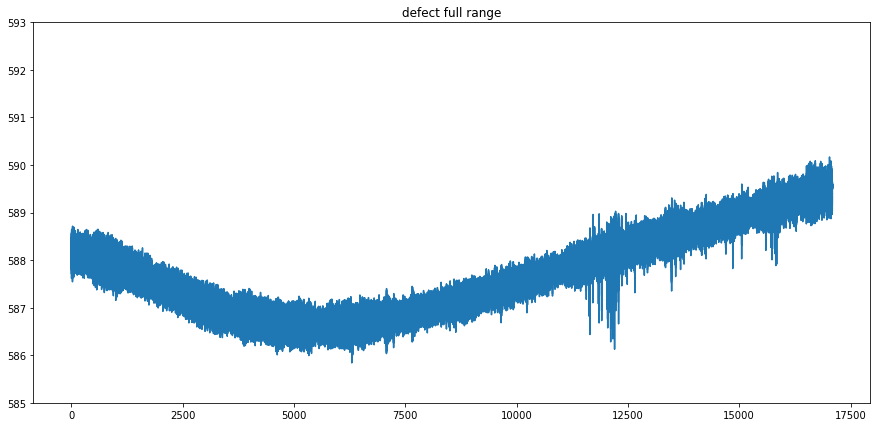

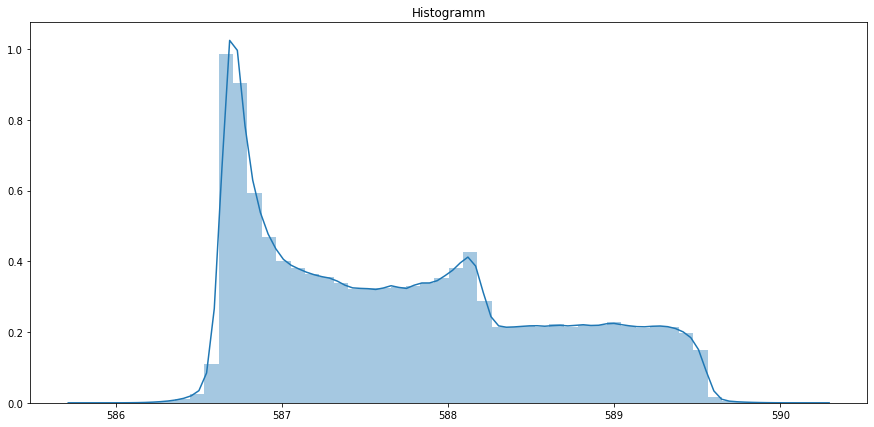

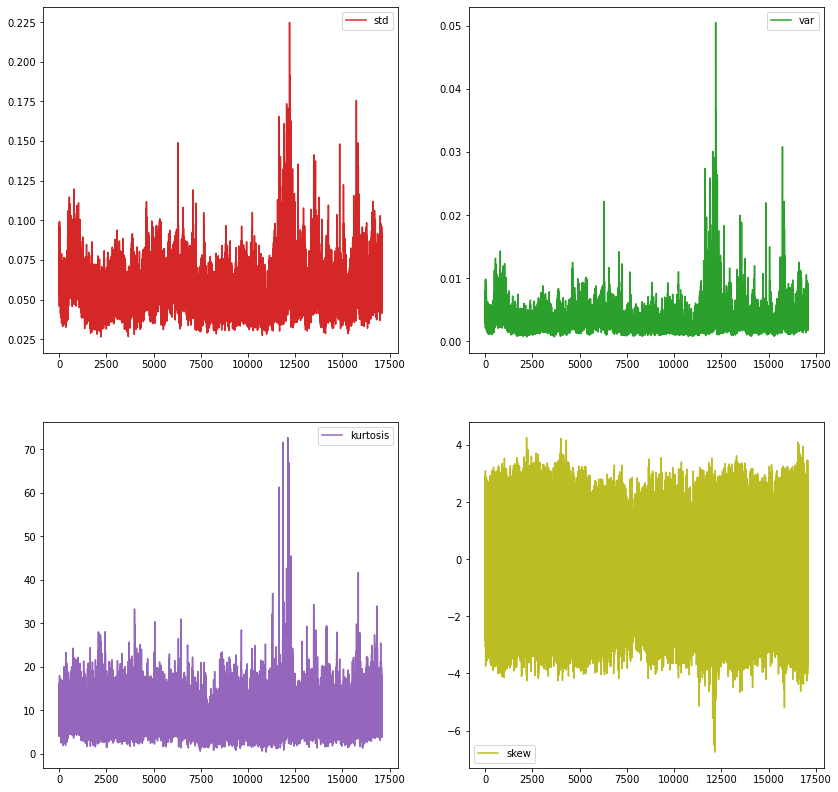

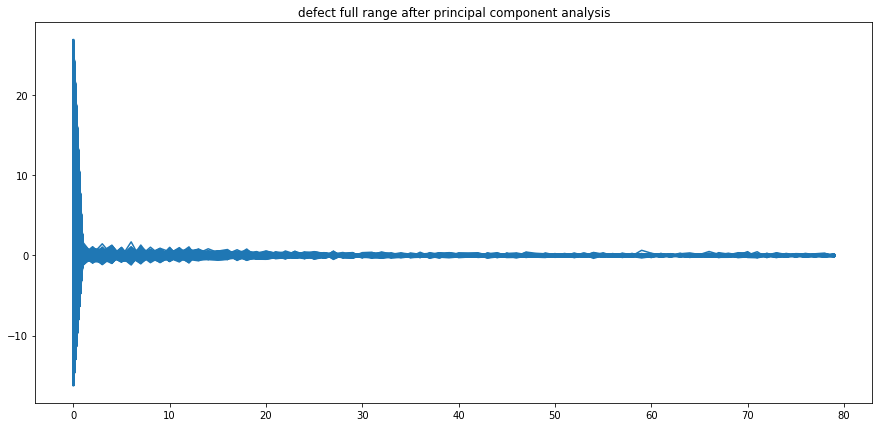

########################################## good (218, 17089) (17089, 80) ##########################################


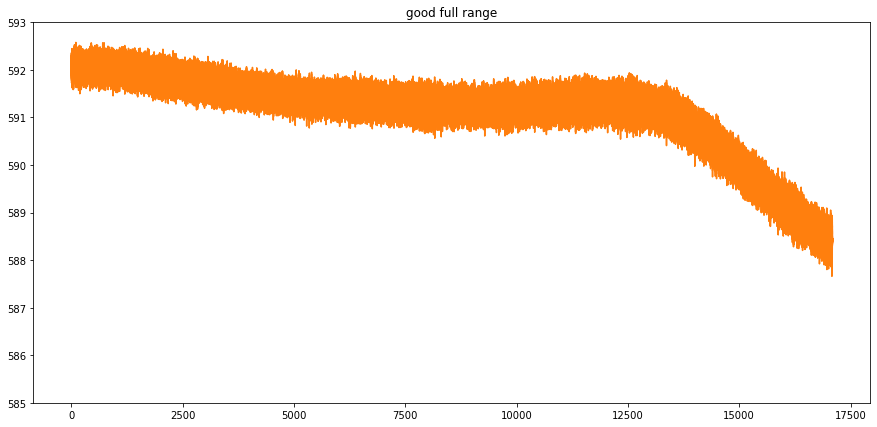

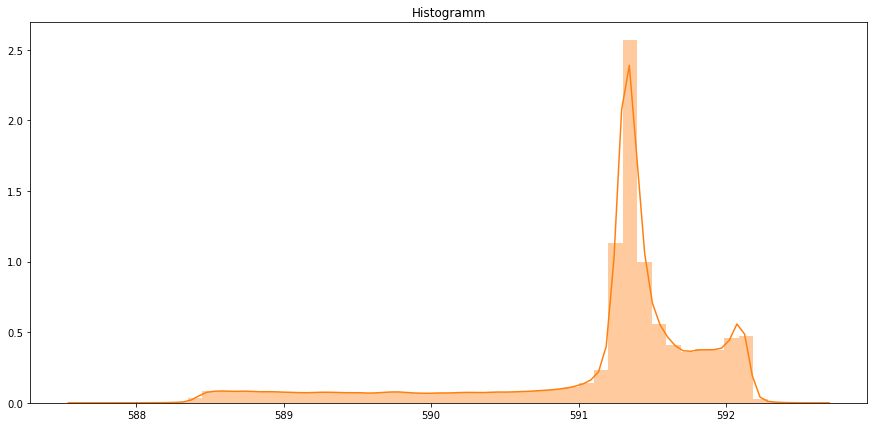

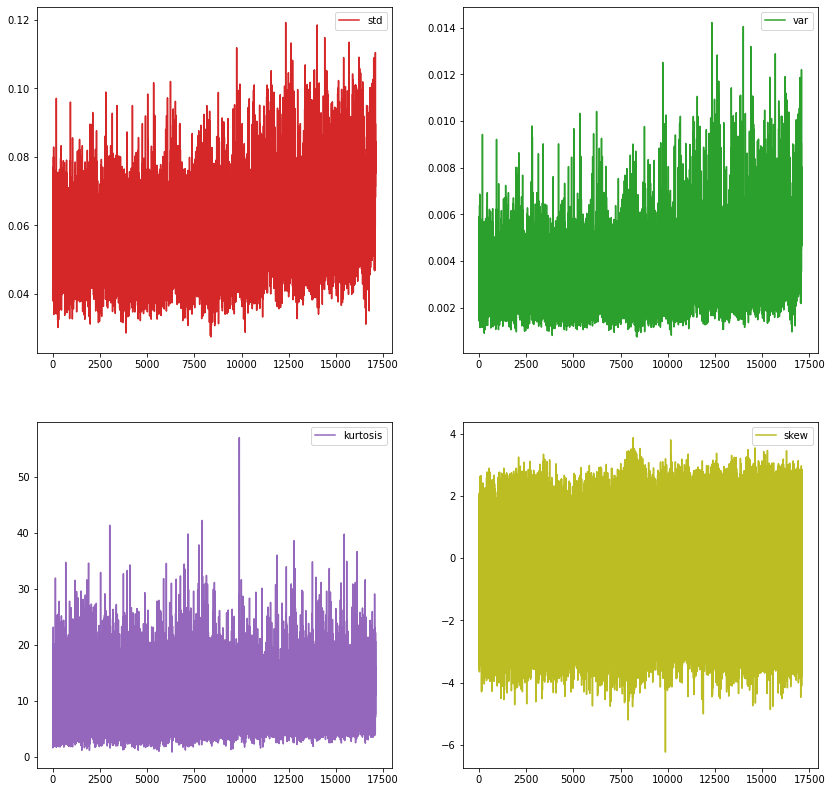

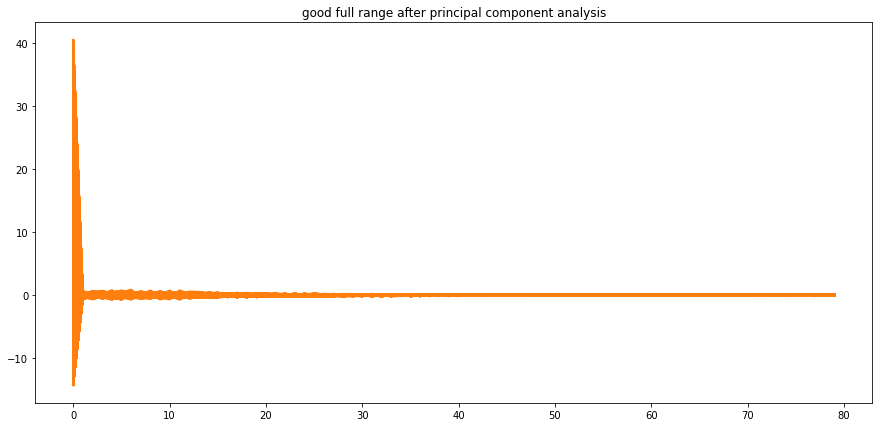

In [6]:
X_train_defect = []
X_train_defect_pca = []
X_train_good = []
X_train_good_pca = []
#######
X_train_pca = []
pcas = []
pca = None

#######


for ind, s, sp, t, lab in zip(count(), series, series_pca, title, [0, 1]):
    
    color = cm.tab10(lab)
    
    #sp = sp.T
    print('##########################################'
          ,t,np.shape(s), np.shape(sp),'##########################################')
    
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
    ax.set_title(f'{t} full range')
    ax.set_ylim([585,593])
    ax.plot(s.T, c=color)
    plt.show()
    
    plot_stats(s, 0, color, True)
    
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f'{t} full range after principal component analysis')
    ax1.plot(sp.T, c=color)
    plt.show()
    
    
    for r in range(len(s.T)):
      
        se = np.array(s[r])
        se_transformed = np.array(sp[r])
        
        #print(np.shape(se))
        
        a,b,c,d = plot_stats(se, 0)

        
        se = np.r_[se, a, b, c, d]
        se_transformed = np.r_[se_transformed, a, b, c, d]
        
        #a,b,c,d = plot_stats(se_transformed, 0)
        
        #print(lab)
        
        if (lab==0):
            X_train_defect.append(se)
            X_train_defect_pca.append(se_transformed)
        else:
            X_train_good.append(se)
            X_train_good_pca.append(se_transformed)


### Daten aufsplitten

In [7]:
G = pd.DataFrame(X_train_good)
D = pd.DataFrame(X_train_defect)

Gp = pd.DataFrame(X_train_good_pca)
Dp = pd.DataFrame(X_train_defect_pca)

print(np.shape(G),np.shape(D),np.shape(Dp),np.shape(Gp))

(17089, 222) (17089, 222) (17089, 84) (17089, 84)


In [8]:
G_train, G_valid, D_train, D_valid = train_test_split(G, D, test_size=0.6666, shuffle = True)
G_test, G_valid, D_test, D_valid = train_test_split(G_valid, D_valid, test_size=0.5, shuffle = True)

print(np.shape(G_train),np.shape(G_valid),np.shape(G_test))
print(np.shape(D_train),np.shape(D_valid),np.shape(D_test))

(5697, 222) (5696, 222) (5696, 222)
(5697, 222) (5696, 222) (5696, 222)


In [9]:
G_trainp, G_validp, D_trainp, D_validp = train_test_split(Gp, Dp, test_size=0.6666, shuffle = True)
G_testp, G_validp, D_testp, D_validp = train_test_split(G_validp, D_validp, test_size=0.5, shuffle = True)

print(np.shape(G_trainp),np.shape(G_validp),np.shape(G_testp))
print(np.shape(D_trainp),np.shape(D_validp),np.shape(D_testp))

(5697, 84) (5696, 84) (5696, 84)
(5697, 84) (5696, 84) (5696, 84)


## FFT Spektrum


In [16]:
fft = []
title = ['defect','good']

#series.append(data[2].T[0:17089].T)
#series.append(data[3].T[0:17089].T)
#series.append(data[2][0:218].T[0:17089].T)
#series.append(data[3].T[0:17089].T)

fft.append(data[0][2:111].T[0:17089])
fft.append(data[1][0:109].T[0:17089])

for s in fft:
    print(np.shape(s))

(17089, 109)
(17089, 109)


## PCA on FFT

In [18]:
fft_pca = []
pcas = []
pca = None



for t in fft:
#
   # for i,_ in enumerate(t):
    

    
    #l = np.size(t,1)/10

    pca = PCA(n_components=50)
    
    pc = pca.fit(t)
    pcas.append(pc)
    trans = pc.transform(t)
    print(np.shape(trans))
    fft_pca.append(trans)

(17089, 50)
(17089, 50)


## plot

########################################## defect (17089, 109) (17089, 50) ##########################################


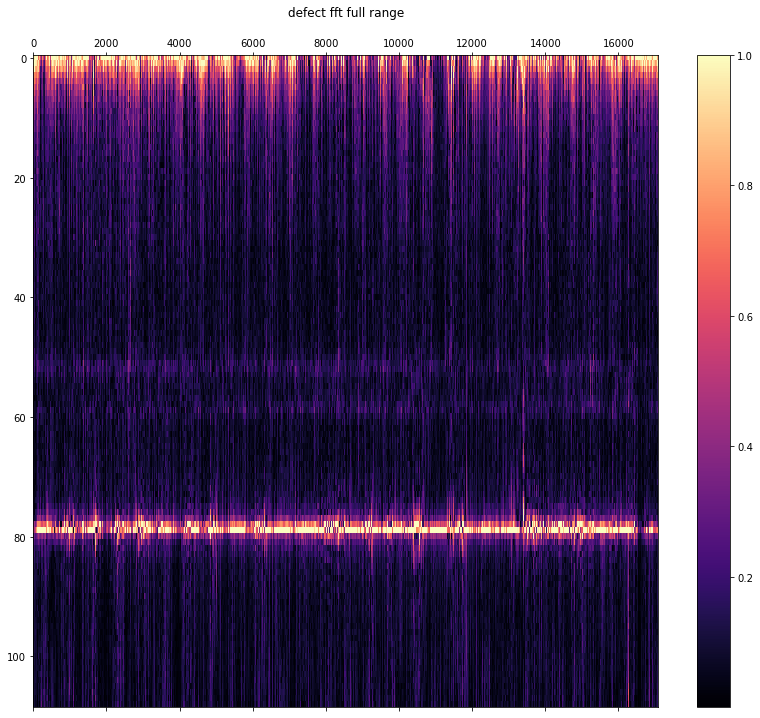

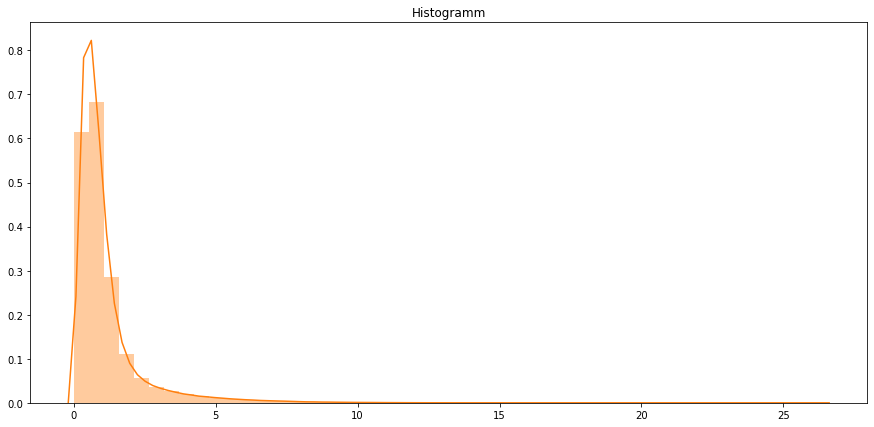

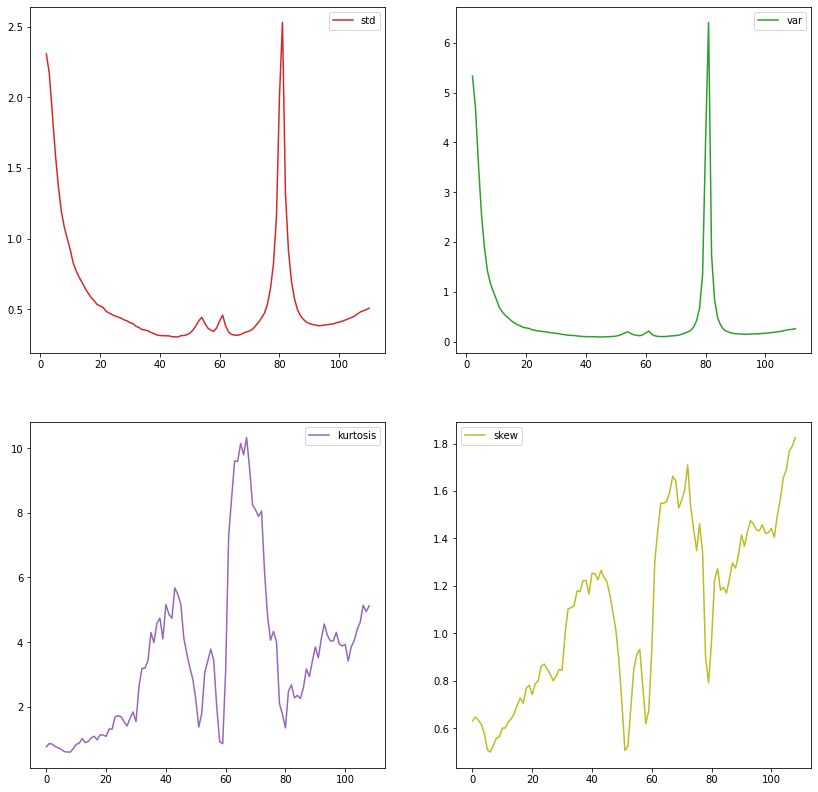

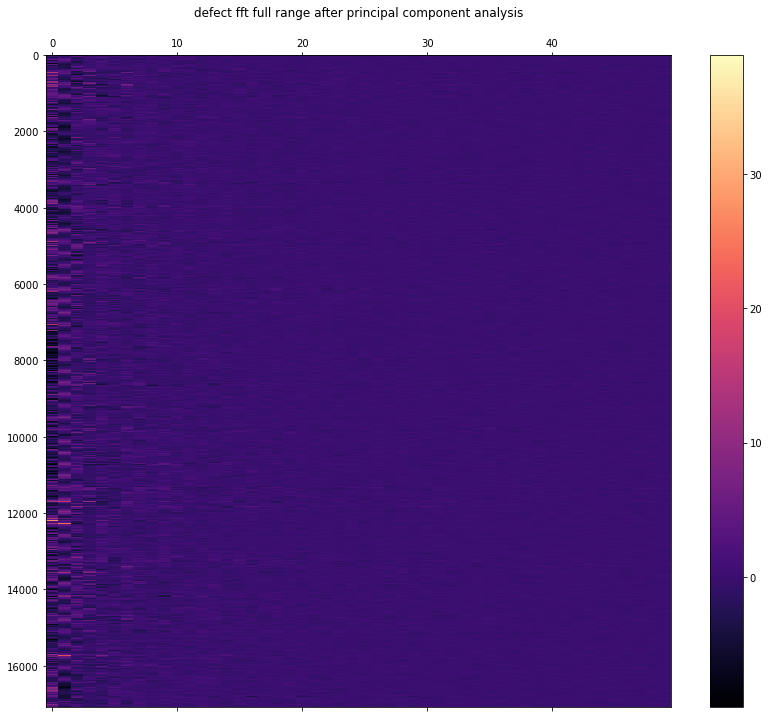

########################################## good (17089, 109) (17089, 50) ##########################################


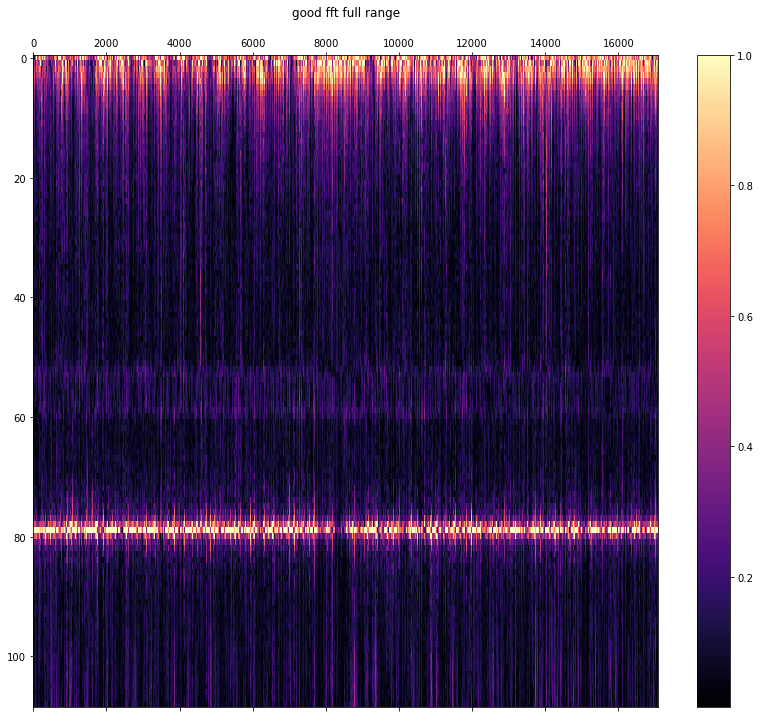

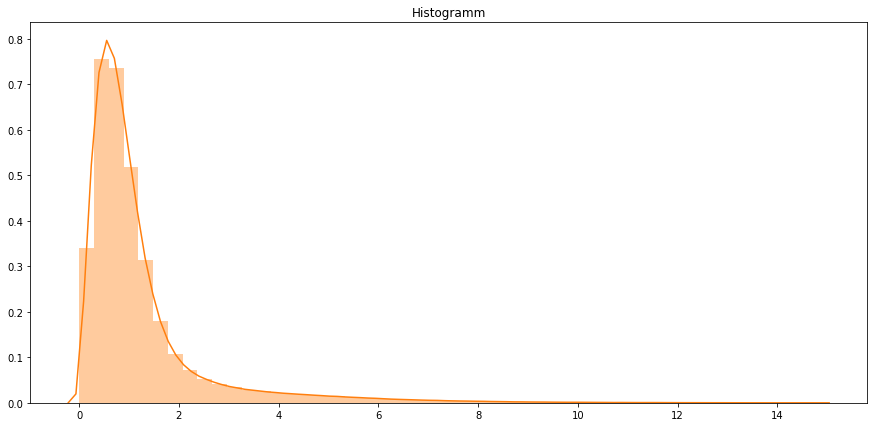

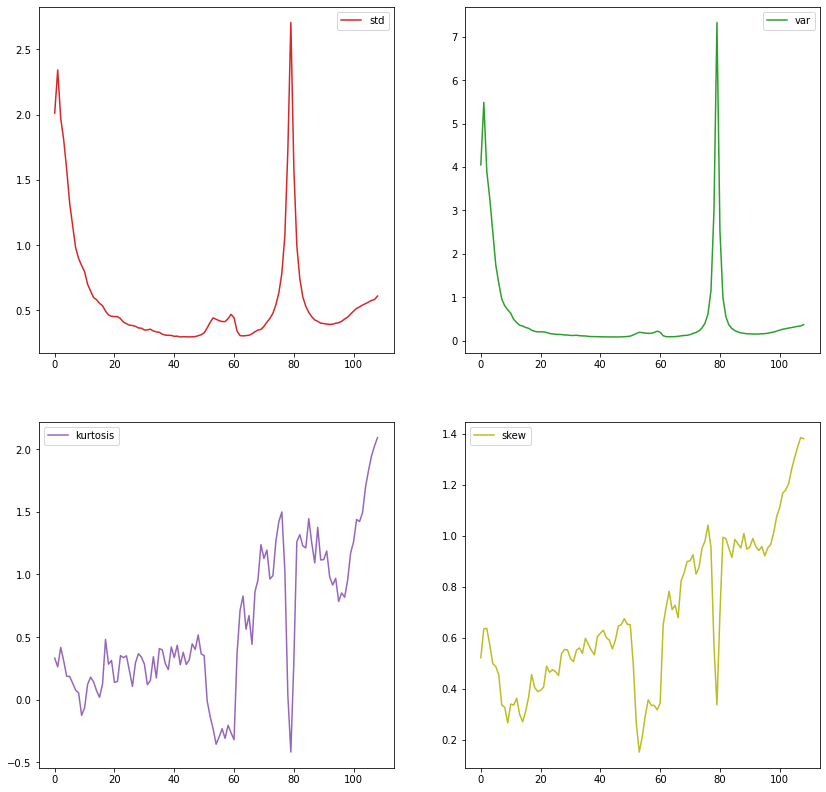

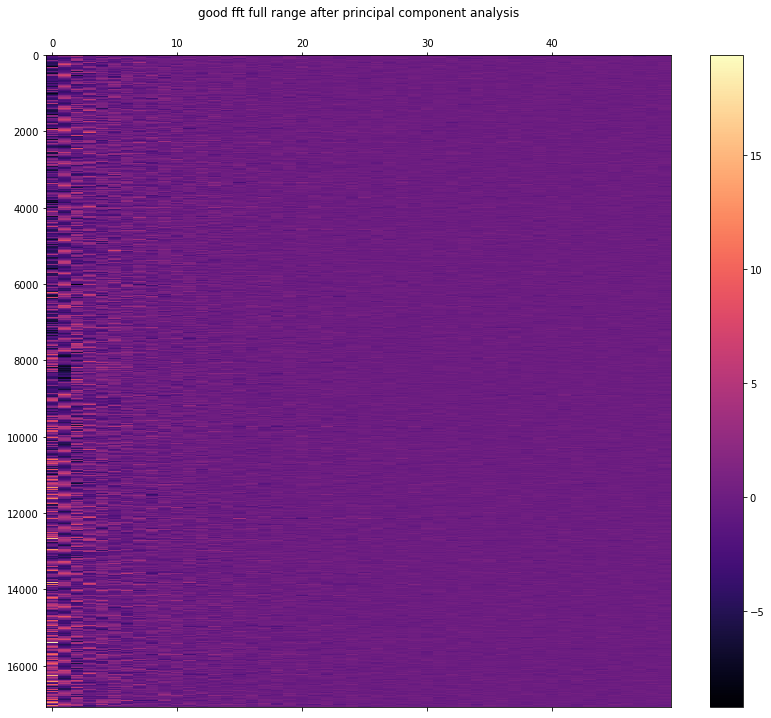

In [13]:
ticks = range(0,len(Dp),1000)
#print(type(data[:-3]),np.shape(data[:-3]))

X_train_fftdefect = []
X_train_fftdefect_pca = []
X_train_fftgood = []
X_train_fftgood_pca = []



for ind, s, sp, t, lab in zip(count(), fft, fft_pca, title, [0, 1]):

    print('##########################################'
          ,t,np.shape(s), np.shape(sp),'##########################################')
    ds = s.rename(columns={x:y for x,y in zip(s.columns,range(0,len(s.columns)))})
    ds = ds.reset_index(drop=True)  
    ds = ds.T / np.max(ds.T)
    
    df = ds  
    
        
    #sp = sp.T
    
    
    fig = plt.figure(figsize=(14,12))
    ax = fig.add_subplot(111)
    ax.set_title(f'{t} fft full range')
   # ax.set_xticklabels(ticks)
    mat = ax.matshow(df, cmap = cm.magma)
    fig.colorbar(mat, ax=ax, orientation='vertical')
    ax.set_aspect('auto')
    plt.show()
    
    plot_stats(s, 0, color, True)
    
    fig = plt.figure(figsize=(14,12))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f'{t} fft full range after principal component analysis')
    mat = ax1.matshow(sp, cmap = cm.magma)
    fig.colorbar(mat, ax=ax1, orientation='vertical')
    ax1.set_aspect('auto')
    plt.show()
    
    #plot_stats(df, 0,'red', True)
    
    for r in range(len(df.T)):
        
        se = np.array(df[r])
        se_transformed = np.array(sp[r])
        
        #print(np.shape(se))
        
        a,b,c,d = plot_stats(se, 0)

        
        se = np.r_[se, a, b, c, d]
        se_transformed = np.r_[se_transformed, a, b, c, d]
        
        #a,b,c,d = plot_stats(se_transformed, 0)
        
        #print(lab)
        
        if (lab==0):
            X_train_fftdefect.append(se)
            X_train_fftdefect_pca.append(se_transformed)
        else:
            X_train_fftgood.append(se)
            X_train_fftgood_pca.append(se_transformed)

    
    

### split


In [21]:
### Daten aufsplitten
Gfft = pd.DataFrame(X_train_fftgood)
Dfft = pd.DataFrame(X_train_fftdefect)

Gpfft = pd.DataFrame(X_train_fftgood_pca)
Dpfft = pd.DataFrame(X_train_fftdefect_pca)

print(np.shape(Gfft),np.shape(Dfft),np.shape(Dpfft),np.shape(Gpfft))

(17089, 113) (17089, 113) (17089, 54) (17089, 54)


In [22]:
G_trainfft, G_validfft, D_trainfft, D_validfft = train_test_split(Gfft, Dfft, test_size=0.6666, shuffle = True)
G_testfft, G_validfft, D_testfft, D_validfft = train_test_split(G_validfft, D_validfft, test_size=0.5, shuffle = True)

print(np.shape(G_trainfft),np.shape(G_validfft),np.shape(G_testfft))
print(np.shape(D_trainfft),np.shape(D_validfft),np.shape(D_testfft))

(5697, 113) (5696, 113) (5696, 113)
(5697, 113) (5696, 113) (5696, 113)


In [23]:
G_trainpfft, G_validpfft, D_trainpfft, D_validpfft = train_test_split(Gpfft, Dpfft, test_size=0.6666, shuffle = True)
G_testpfft, G_validpfft, D_testpfft, D_validpfft = train_test_split(G_validpfft, D_validpfft, test_size=0.5, shuffle = True)

print(np.shape(G_trainpfft),np.shape(G_validpfft),np.shape(G_testpfft))
print(np.shape(D_trainpfft),np.shape(D_validpfft),np.shape(D_testpfft))

(5697, 54) (5696, 54) (5696, 54)
(5697, 54) (5696, 54) (5696, 54)


Anschließend wird ein kombiniertes Datenset aus einer Verkettung des FFT Spektrums und des realspace vorgenommen. Der Wertebereich wird Sakliert und die Dimensionen werden anschließend wieder durch PCA reduziert.

# kombiniertes Datenset FFT Spektrum+realspace

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

In [24]:
comb = []
title = ['defect','good']

datafft= [data[0][2:111].T[0:17089], data[1][0:109].T[0:17089]]
datareal = [data[2][0:218].T[0:17089], data[3].T[0:17089]]

for ind, d in enumerate(datafft):
    datafft[ind] = StandardScaler().fit_transform(d)

for ind, d in enumerate(datareal):
    datareal[ind] = StandardScaler().fit_transform(d)

    
    
combi0 = np.c_[datafft[0], datareal[0]]
combi1 = np.c_[datafft[1], datareal[1]]


print(np.shape(combi0),np.shape(combi1))

comb.append(combi0)
comb.append(combi1)




(17089, 327) (17089, 327)


## PCA on combined Dataset

In [25]:
comb_pca = []
pcas = []
pca = None



for t in comb:
#
   # for i,_ in enumerate(t):
    

    
    #l = np.size(t,1)/10

    pca = PCA(n_components=100)
    
    pc = pca.fit(t)
    pcas.append(pc)
    trans = pc.transform(t)
    print(np.shape(trans))
    comb_pca.append(trans)

(17089, 100)
(17089, 100)


## plot

0


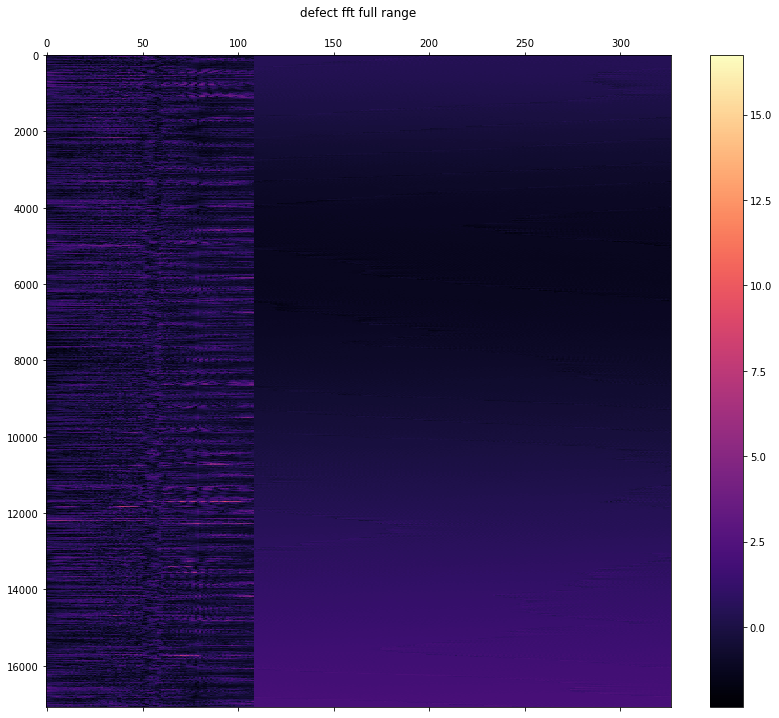

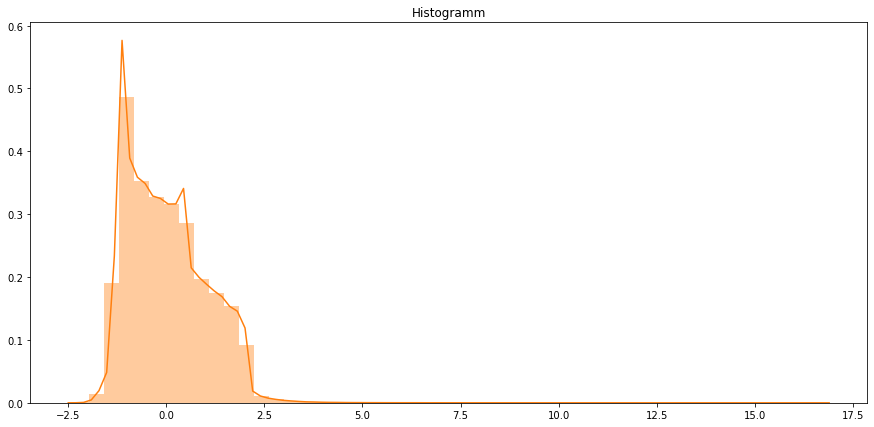

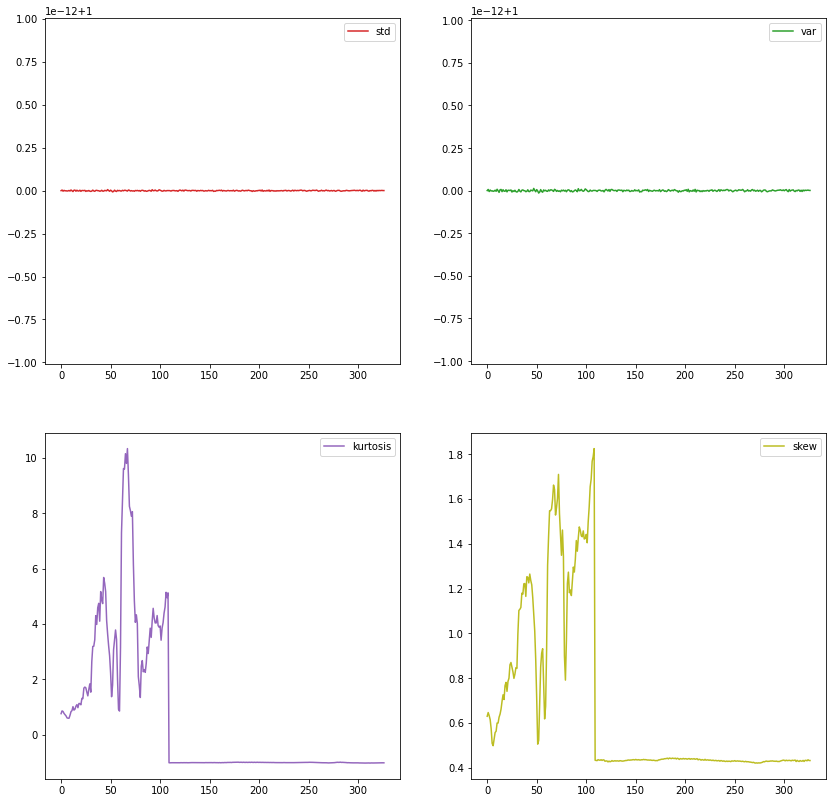

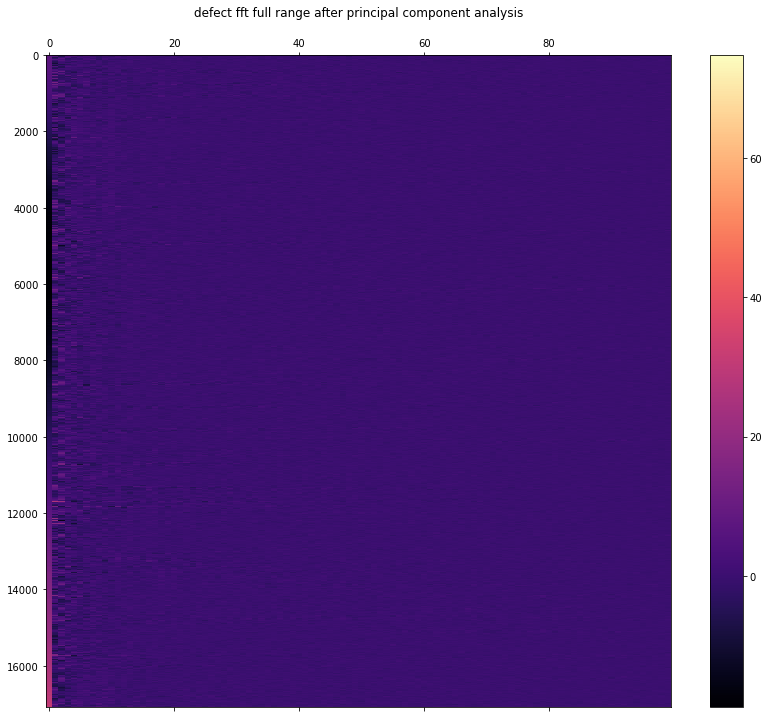

1


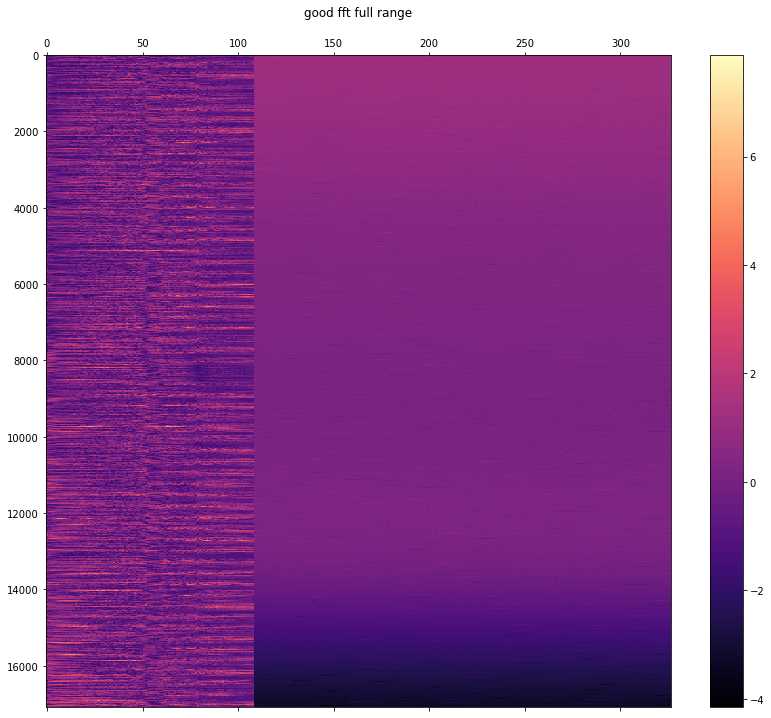

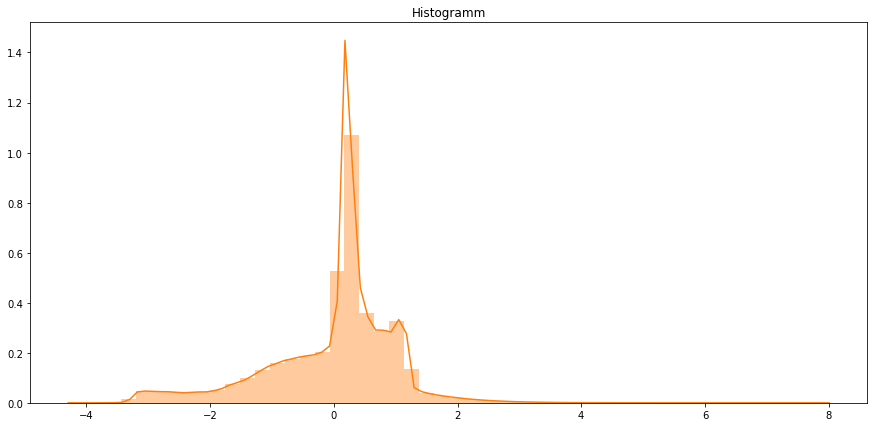

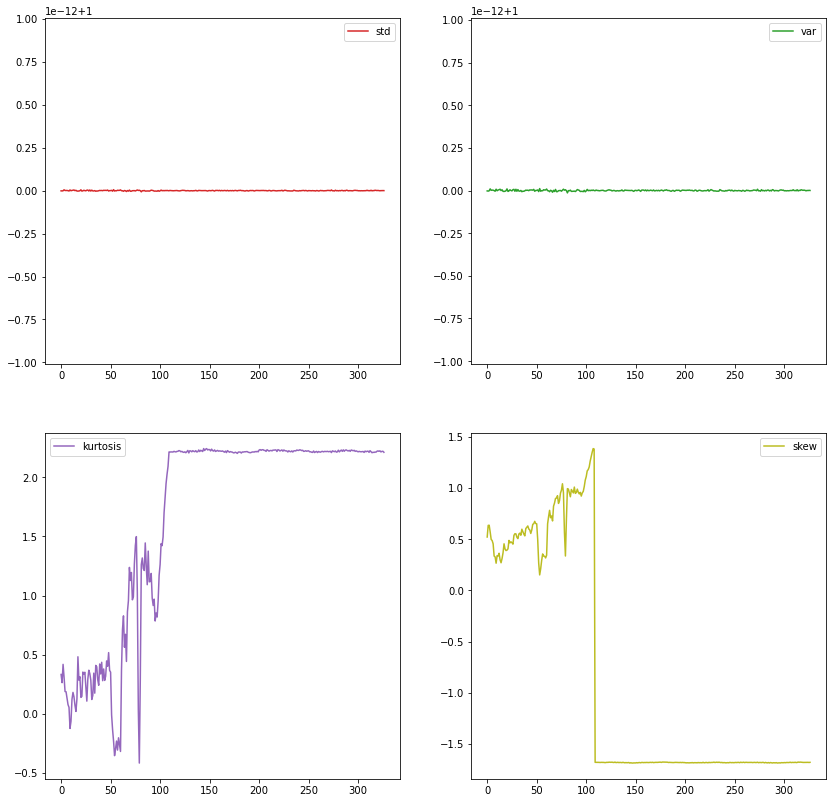

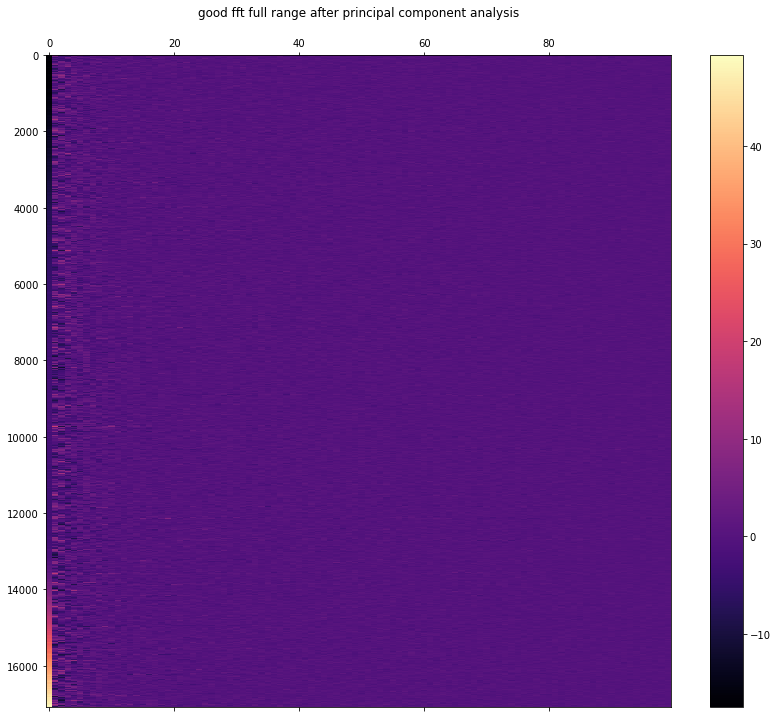

In [26]:
X_train_combdefect = []
X_train_combdefect_pca = []
X_train_combgood = []
X_train_combgood_pca = []


for ind, s, sp, t, lab in zip(count(), comb, comb_pca, title, [0, 1]):

    print(ind)
    df = s  
    dp = sp
    
    fig = plt.figure(figsize=(14,12))
    ax = fig.add_subplot(111)
    ax.set_title(f'{t} fft full range')
   # ax.set_xticklabels(ticks)
    mat = ax.matshow(df, cmap = cm.magma)
    fig.colorbar(mat, ax=ax, orientation='vertical')
    ax.set_aspect('auto')
    plt.show()
    
    plot_stats(s, 0, color, True)
    
    fig = plt.figure(figsize=(14,12))
    ax1 = fig.add_subplot(111)
    ax1.set_title(f'{t} fft full range after principal component analysis')
    mat = ax1.matshow(dp, cmap = cm.magma)
    fig.colorbar(mat, ax=ax1, orientation='vertical')
    ax1.set_aspect('auto')
    plt.show()
    
    
    for r in range(len(df)):
        
        se = np.array(df[r])
        se_transformed = np.array(sp[r])
        
        #print(np.shape(se))
        
        a,b,c,d = plot_stats(se, 0)

        
        se = np.r_[se, a, b, c, d]
        se_transformed = np.r_[se_transformed, a, b, c, d]
        
        #a,b,c,d = plot_stats(se_transformed, 0)
        
        #print(lab)
        
        if (lab==0):
            X_train_combdefect.append(se)
            X_train_combdefect_pca.append(se_transformed)
        else:
            X_train_combgood.append(se)
            X_train_combgood_pca.append(se_transformed)

In [27]:
Gcomb = pd.DataFrame(X_train_combgood)
Dcomb = pd.DataFrame(X_train_combdefect)

Gpcomb = pd.DataFrame(X_train_combgood_pca)
Dpcomb = pd.DataFrame(X_train_combdefect_pca)

print(np.shape(Gcomb),np.shape(Dcomb),np.shape(Dpcomb),np.shape(Gpcomb))

(17089, 331) (17089, 331) (17089, 104) (17089, 104)


In [28]:
G_traincomb, G_validcomb, D_traincomb, D_validcomb = train_test_split(Gcomb, Dcomb, test_size=0.6666, shuffle = True)
G_testcomb, G_validcomb, D_testcomb, D_validcomb = train_test_split(G_validcomb, D_validcomb, test_size=0.5, shuffle = True)

print(np.shape(G_traincomb),np.shape(G_validcomb),np.shape(G_testcomb))
print(np.shape(D_traincomb),np.shape(D_validcomb),np.shape(D_testcomb))

(5697, 331) (5696, 331) (5696, 331)
(5697, 331) (5696, 331) (5696, 331)


In [29]:
G_trainpcomb, G_validpcomb, D_trainpcomb, D_validpcomb = train_test_split(Gpcomb, Dpcomb, test_size=0.6666, shuffle = True)
G_testpcomb, G_validpcomb, D_testpcomb, D_validpcomb = train_test_split(G_validpcomb, D_validpcomb, test_size=0.5, shuffle = True)

print(np.shape(G_trainpcomb),np.shape(G_validpcomb),np.shape(G_testpcomb))
print(np.shape(D_trainpcomb),np.shape(D_validpcomb),np.shape(D_testpcomb))

(5697, 104) (5696, 104) (5696, 104)
(5697, 104) (5696, 104) (5696, 104)


## GMM

Es werden verschiedene GMM erzeugt, wobei zunächst die optimale Anzahl der Gaußverteilungen ermittelt wird.


### estimate number of components

In [30]:

X_train = [G_trainp, G_trainpfft, G_trainpcomb]

min_cluster = 1
max_cluster = 15

h, w = len(X_train), max_cluster;
bic = [[0 for x in range(w)] for y in range(h)] 


for ind, ds in enumerate(X_train):
    print('GM on ds',ind+1,'with shape',np.shape(ds),'for',max_cluster,'components')
    for i in range(min_cluster, max_cluster):
        
        gm = GaussianMixture(n_components=4,
                               covariance_type='diag',
                               tol=0.0005, 
                               reg_covar=0.0005,  
                               max_iter=100,
                               n_init=10,
                               init_params='kmeans',
                               verbose=0)

        gm.fit(ds)

        bic[ind][i] = gm.bic(ds)

GM on ds 1 with shape (5697, 84) for 15 components
GM on ds 2 with shape (5697, 54) for 15 components
GM on ds 3 with shape (5697, 104) for 15 components


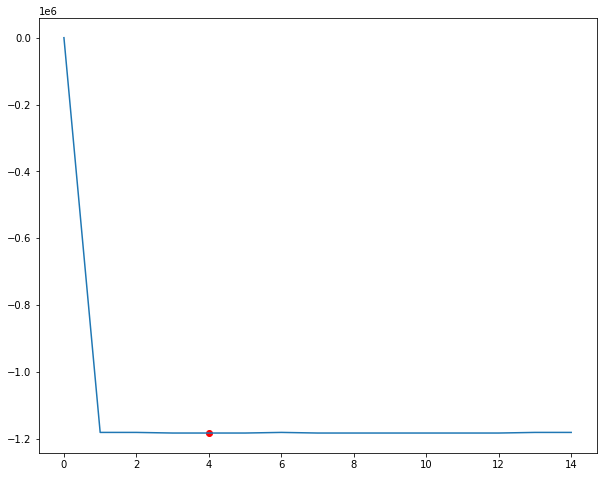

min -1183343.7187868385 at 4


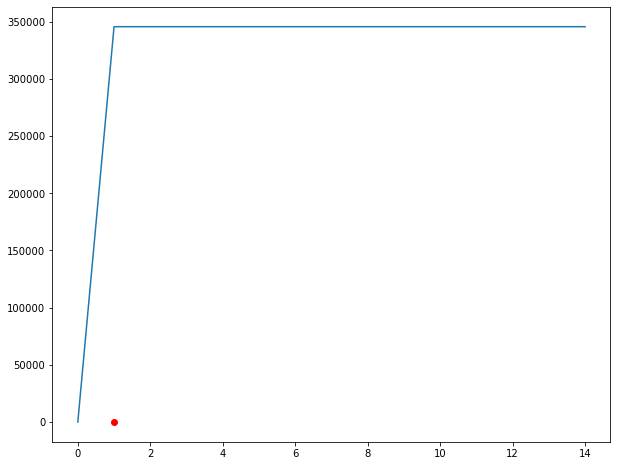

min 0.0 at 1


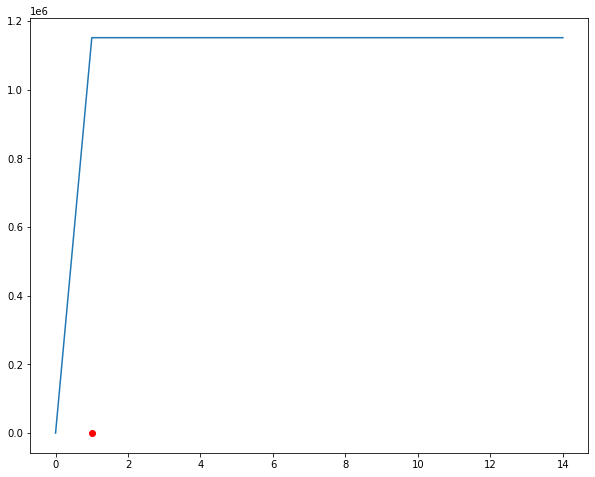

min 0.0 at 1


In [31]:
n_best =[]

for b in bic:
    fig = plt.figure(figsize=(10,8))
    #print(np.argmin(b))
    plt.plot(b)
    plt.scatter(range(1, max_cluster+1)[np.argmin(b)], np.min(b), color='r')
    plt.show()
    print('min',np.min(b),'at',range(1, max_cluster+1)[np.argmin(b)])
    n_best.append(np.min(b))

### GMM on realspace

In [63]:
trainset = G_trainp

# estimate for y_train==1 (good lines)
print('fit on',np.shape(trainset))
gm_realspace = GaussianMixture(n_components=4,
                               covariance_type='diag',
                               tol=0.000005, 
                               reg_covar=0.00000005,  
                               max_iter=100,
                               n_init=10,
                               init_params='kmeans',
                               verbose=0)

gm_realspace.fit(trainset)

print('GMM converged =',gm_realspace.converged_)
print('in',gm_realspace.n_iter_,'iters')
#models.append(gm_realspace)

fit on (5697, 84)
GMM converged = True
in 80 iters


In [64]:
print('evaluate realspace\n\n')

threshold = 99.994

y_pred_gmm, y_pred_gmm_good = eval_gmm(gm_realspace, Gp, G_trainp, G_testp, G_validp, Dp, threshold)

evaluate realspace


traindata: 1
testdata: 1
validationsdata: 1
######################
 estimatet on whole Good Lines DS: 3 


estimatet on whole Defect Lines DS: 7


### GMM on fft

In [34]:
trainset = G_trainpfft

# estimate for y_train==1 (good lines) G_trainpfft
print('fit on',np.shape(trainset))
gm_fft = GaussianMixture(n_components=4,
                               covariance_type='diag',
                               tol=0.005, 
                               reg_covar=0.005, 
                               max_iter=100,
                               n_init=10,
                               init_params='kmeans',
                               verbose=0)

gm_fft.fit(trainset)

print('GMM converged =',gm_fft.converged_)
print('in',gm_fft.n_iter_,'iters')
#models.append(gm_realspace)


fit on (5697, 54)
GMM converged = True
in 13 iters


In [35]:
print('evaluate fft\n\n')
threshold = 99.986

y_pred_gmmfft, y_pred_gmmfft_good = eval_gmm(gm_fft, Gpfft, G_trainpfft, G_testpfft, G_validpfft, Dpfft, threshold)

evaluate fft


traindata: 1
testdata: 1
validationsdata: 2
######################
 estimatet on whole Good Lines DS: 4 


estimatet on whole Defect Lines DS: 20


### GMM on combined

In [36]:
trainset = G_trainpcomb

# estimate for good lines
print('fit on',np.shape(trainset))
gm_comb = GaussianMixture(n_components=2,
                               covariance_type='diag',
                               tol=0.5, 
                               reg_covar=0.5, 
                               max_iter=100,
                               n_init=10,
                               init_params='kmeans',
                               verbose=0)

gm_comb.fit(trainset)

print('GMM converged =',gm_comb.converged_)
print('in',gm_comb.n_iter_,'iters')
#models.append(gm_realspace)


fit on (5697, 104)
GMM converged = True
in 2 iters


In [37]:
print('evaluate combined')
threshold = 99.999

y_pred_gmmcomb, y_pred_gmmcomb_good = eval_gmm(gm_comb, Gpcomb, G_trainpcomb, G_testpcomb, G_validpcomb, Dpcomb, threshold)

evaluate combined
traindata: 1
testdata: 0
validationsdata: 0
######################
 estimatet on whole Good Lines DS: 1 


estimatet on whole Defect Lines DS: 8


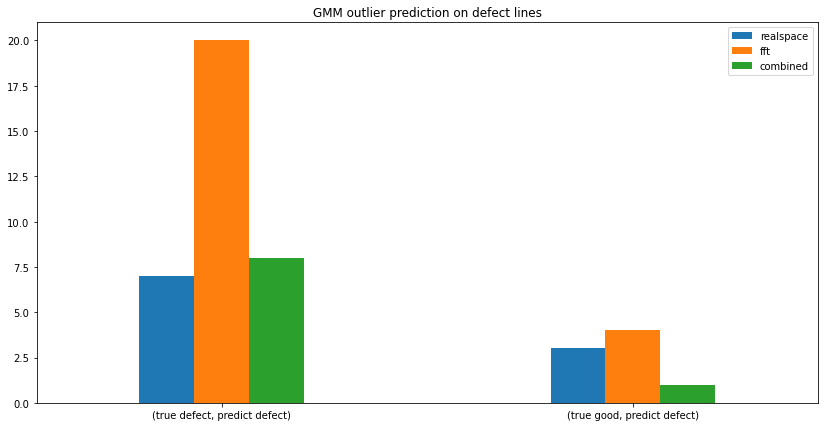

             true defect      true good
          predict defect predict defect
realspace              7              3
fft                   20              4
combined               8              1


In [65]:
unique, counts = np.unique(y_pred_gmm, return_counts=True)
uniquefft, countsfft = np.unique(y_pred_gmmfft, return_counts=True)
uniquecomb, countscomb = np.unique(y_pred_gmmcomb, return_counts=True)

uniquegood, countsgood = np.unique(y_pred_gmm_good, return_counts=True)
uniquefftgood, countsfftgood = np.unique(y_pred_gmmfft_good, return_counts=True)
uniquecombgood, countscombgood = np.unique(y_pred_gmmcomb_good, return_counts=True)


index = ['predict defect']

df_gmmdefect = pd.DataFrame({'realspace': counts[0],
                   'fft': countsfft[0],
                   'combined': countscomb[0]}, index=index)

df_gmmgood = pd.DataFrame({'realspace': countsgood[0],
                   'fft': countsfftgood[0],
                   'combined': countscombgood[0]}, index=index)

df_gmm = pd.concat([df_gmmdefect, df_gmmgood], axis=0, sort=False, keys=['true defect','true good'])

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111)
ax.set_title('GMM outlier prediction on defect lines')
df_gmm.plot.bar(rot=0, ax=ax, width = 0.4)
plt.show()
print(df_gmm.T)


#false negative label for viz
y_pred_gmm[y_pred_gmm_good==0] = 2
y_pred_gmmfft[y_pred_gmmfft_good==0] = 2
y_pred_gmmcomb[y_pred_gmmcomb_good==0] = 2

# Autoencoder

Es werden verschiedene Autoencoder mit dem trainingset angelernt und zunächst nur mit den goodlines validiert.

## AE on realspace

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84)]              0         
_________________________________________________________________
dense (Dense)                (None, 42)                3570      
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                903       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 42)                924       
_________________________________________________________________
dense_3 (Dense)              (None, 84)                3612  

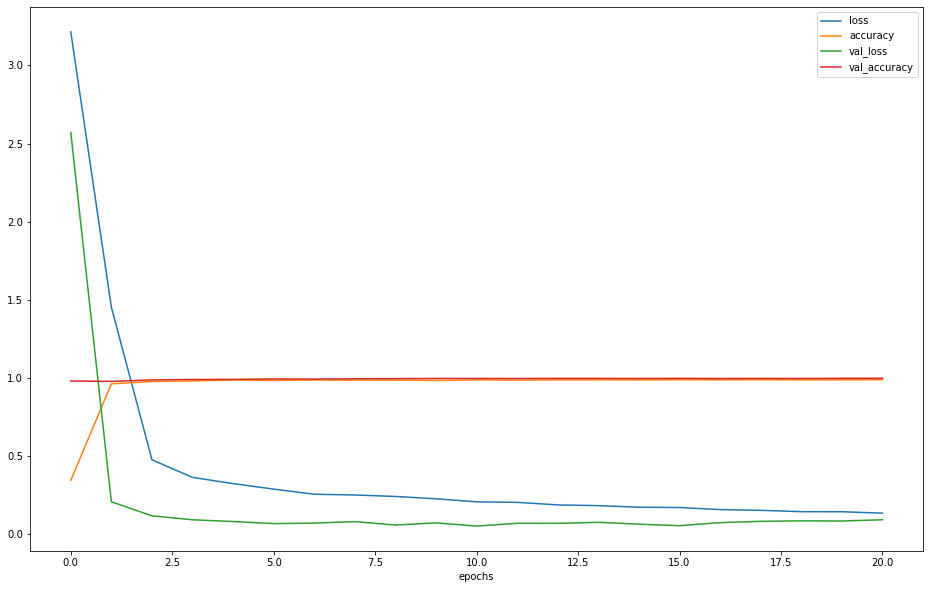

min val loss: 0.053068071603775024


In [39]:
autoencoder, history = setup_ae_and_train(30, 100, 10, G_trainp.shape[1], G_trainp, G_validp)
    

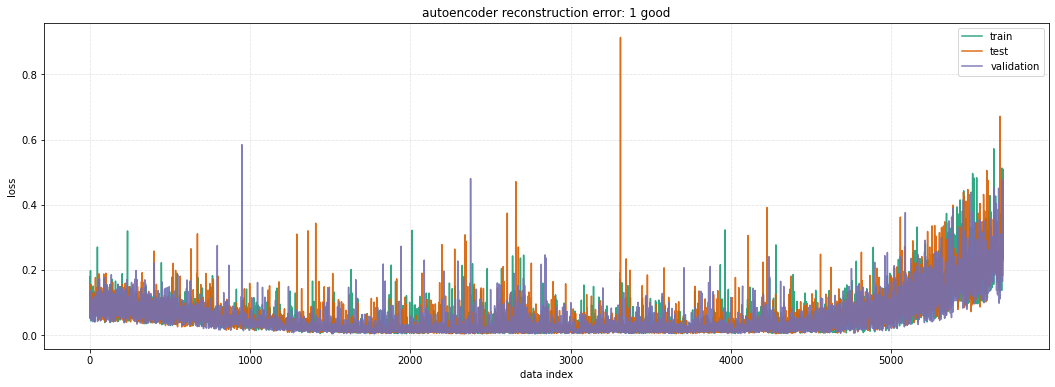

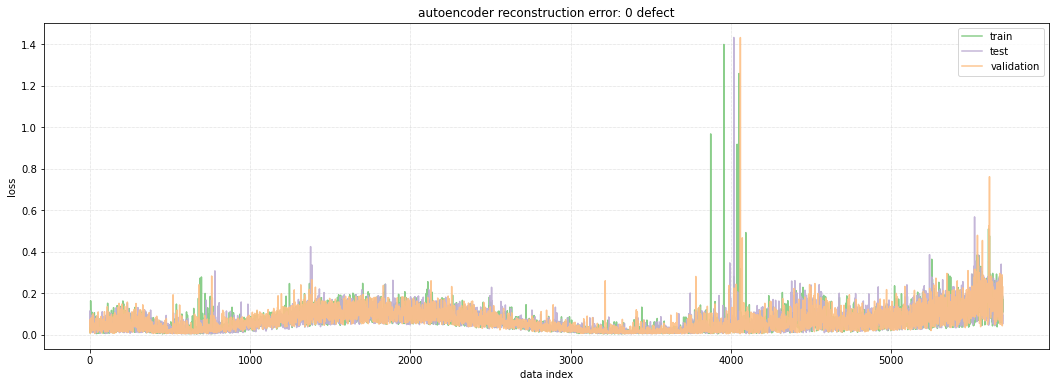

In [56]:

        
lab = ['train','test','validation']
title = ['1 good', '0 defect']
sets = [[G_trainp, G_testp, G_validp], [D_trainp, D_testp, D_validp]]

ae_reconstruct(lab, title, sets, autoencoder)


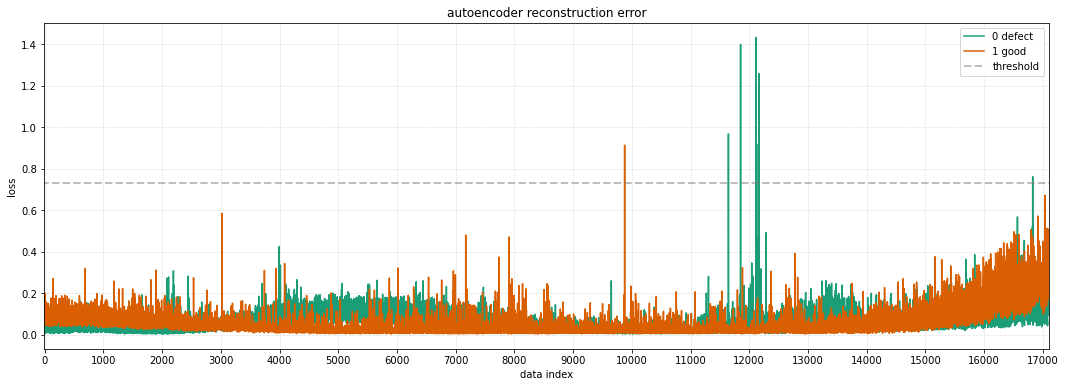

In [57]:
title = ['0 defect', '1 good']
sets = [Dp, Gp]
threshold, losses = ae_reconstruct_fullset(title, sets, autoencoder)

## AE on FFT

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1485      
_________________________________________________________________
dropout_2 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 13)                364       
_________________________________________________________________
dropout_3 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 27)                378       
_________________________________________________________________
dense_7 (Dense)              (None, 54)                1512

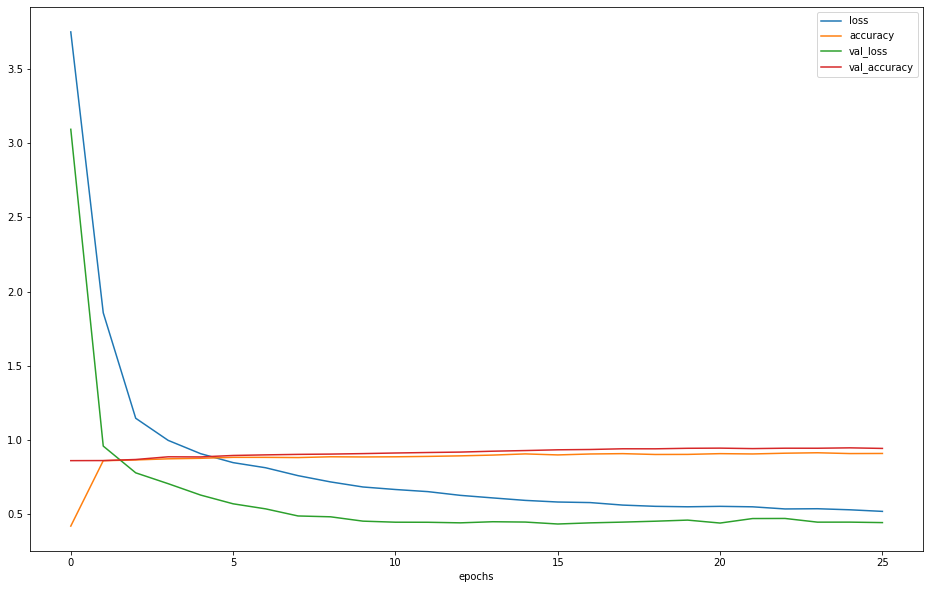

min val loss: 0.4309772551059723


In [42]:
autoencoderfft, historyfft = setup_ae_and_train(30, 100, 10, Gpfft.shape[1], G_trainpfft, G_validpfft)

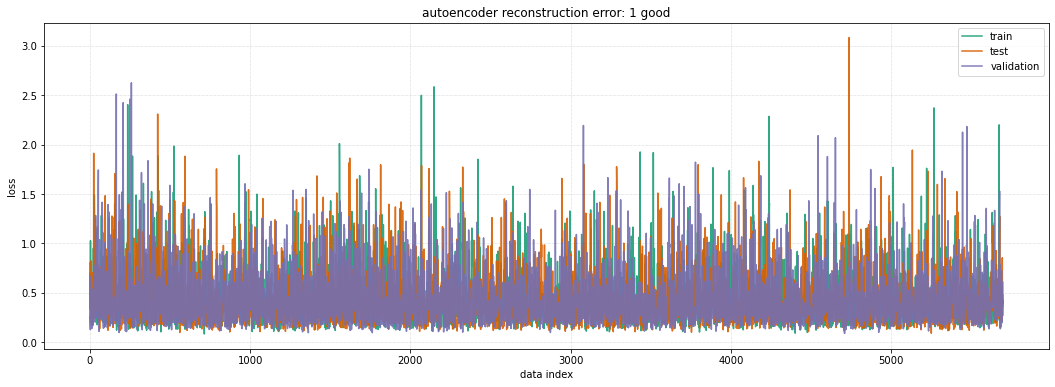

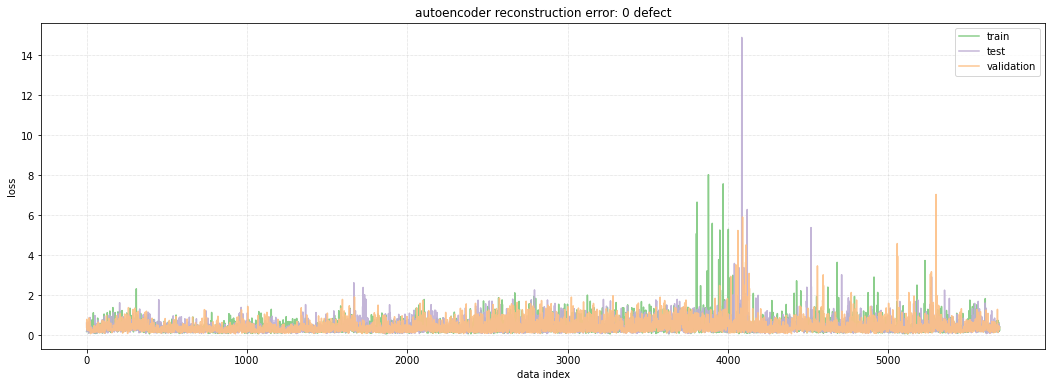

In [43]:
lab = ['train','test','validation']
title = ['1 good', '0 defect']
sets = [[G_trainpfft, G_testpfft, G_validpfft], [D_trainpfft, D_testpfft, D_validpfft]]
    
    
ae_reconstruct(lab, title, sets, autoencoderfft)

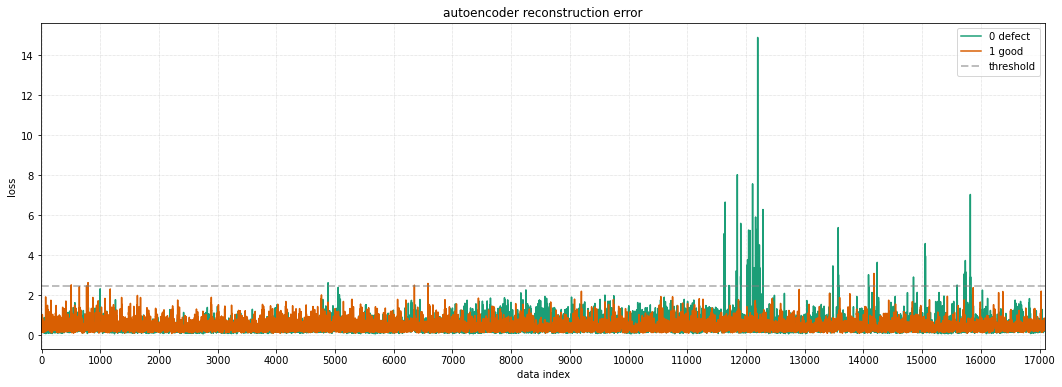

In [58]:
title = ['0 defect', '1 good']
sets = [Dpfft, Gpfft]
thresholdfft, lossesfft = ae_reconstruct_fullset(title, sets, autoencoderfft)

# AE on combined Dataset

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 104)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 52)                5460      
_________________________________________________________________
dropout_4 (Dropout)          (None, 52)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 26)                1378      
_________________________________________________________________
dropout_5 (Dropout)          (None, 26)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 52)                1404      
_________________________________________________________________
dense_11 (Dense)             (None, 104)               5512

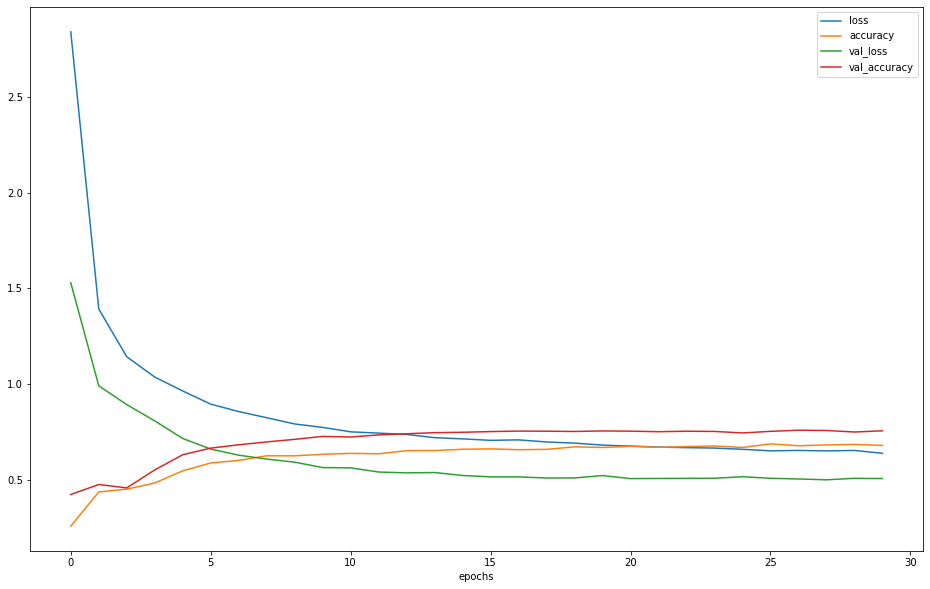

min val loss: 0.5019756555557251


In [45]:
autoencodercomb, historycomb = setup_ae_and_train(30, 100, 10, Gpcomb.shape[1], G_trainpcomb, G_validpcomb)

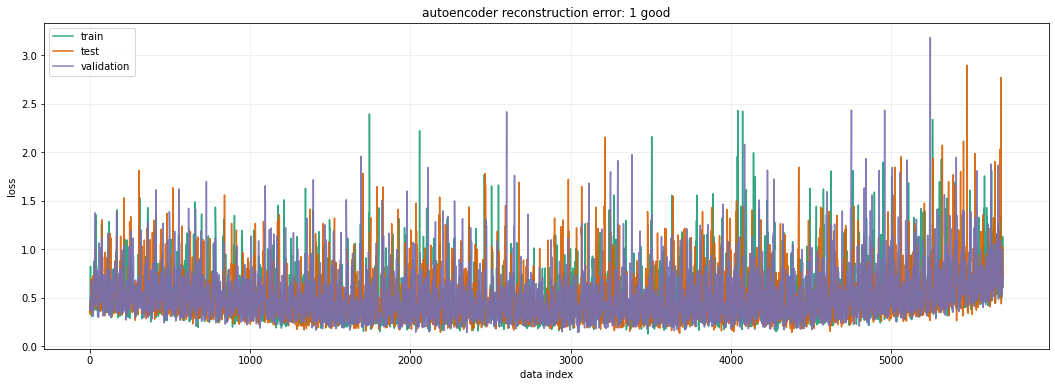

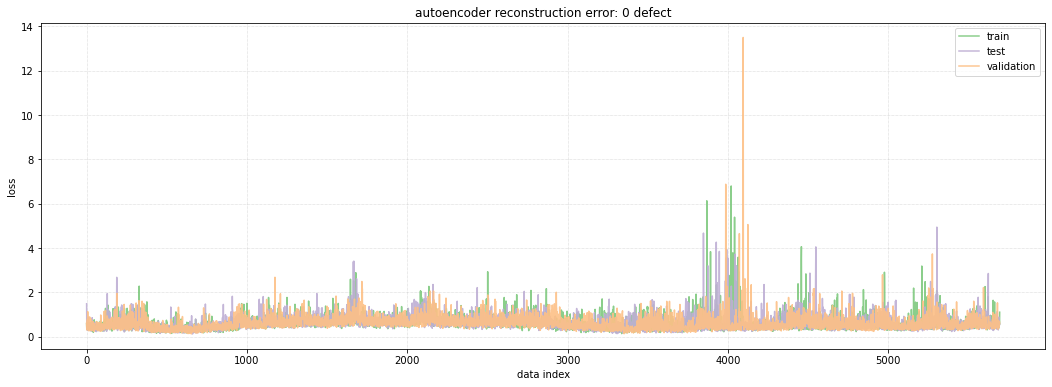

In [53]:
lab = ['train','test','validation']
title = ['1 good', '0 defect']
sets = [[G_trainpcomb, G_testpcomb, G_validpcomb], [D_trainpcomb, D_testpcomb, D_validpcomb]]

ae_reconstruct(lab, title, sets, autoencodercomb)

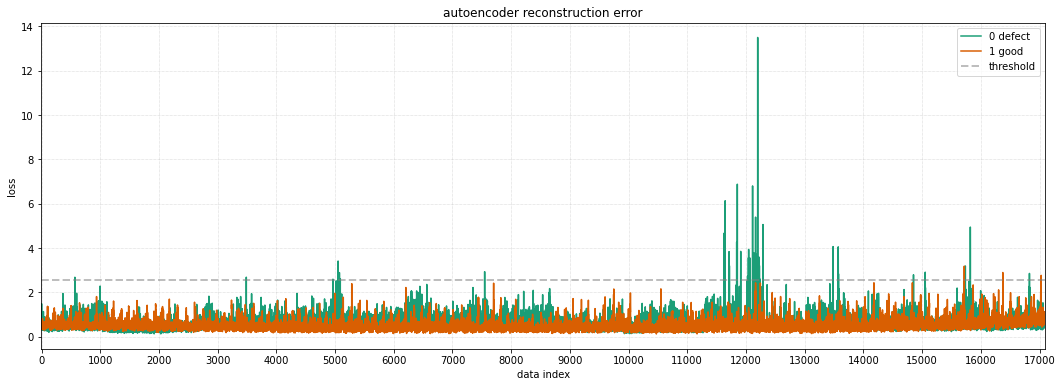

In [59]:
title = ['0 defect', '1 good']
sets = [Dpcomb, Gpcomb]
thresholdcomb, lossescomb = ae_reconstruct_fullset(title, sets, autoencodercomb)

## classprediciton with autoencoder reconstruction error

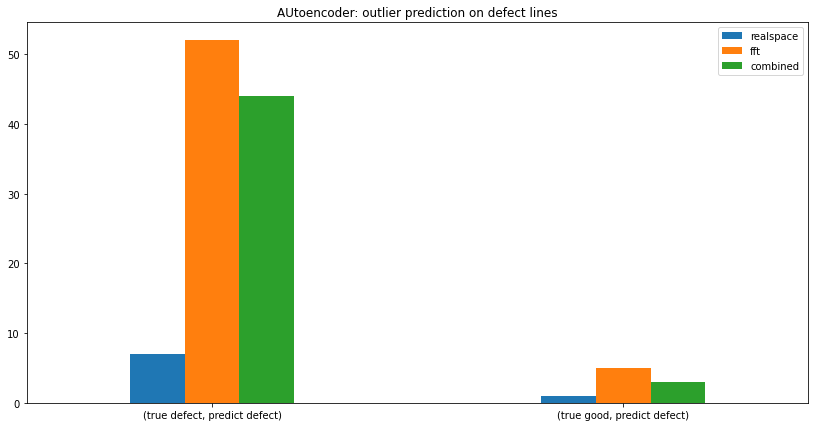

             true defect      true good
          predict defect predict defect
realspace              7              1
fft                   52              5
combined              44              3


In [61]:
y_pred_ae = ae_classy(losses[0], threshold)
y_pred_aefft = ae_classy(lossesfft[0], thresholdfft)
y_pred_aecomb = ae_classy(lossescomb[0], thresholdcomb)

y_pred_ae_good = ae_classy(losses[1], threshold)
y_pred_aefft_good = ae_classy(lossesfft[1], thresholdfft)
y_pred_aecomb_good = ae_classy(lossescomb[1], thresholdcomb)

unique, counts = np.unique(y_pred_ae, return_counts=True)
uniquefft, countsfft = np.unique(y_pred_aefft, return_counts=True)
uniquecomb, countscomb = np.unique(y_pred_aecomb, return_counts=True)

uniquegood, countsgood = np.unique(y_pred_ae_good, return_counts=True)
uniquefftgood, countsfftgood = np.unique(y_pred_aefft_good, return_counts=True)
uniquecombgood, countscombgood = np.unique(y_pred_aecomb_good, return_counts=True)



index = ['predict defect']

df_aedefect = pd.DataFrame({'realspace': counts[0],
                   'fft': countsfft[0],
                   'combined': countscomb[0]}, index=index)

df_aegood = pd.DataFrame({'realspace': countsgood[0],
                   'fft': countsfftgood[0],
                   'combined': countscombgood[0]}, index=index)

df_ae = pd.concat([df_aedefect, df_aegood], axis=0, sort=False, keys=['true defect','true good'])


fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111)
ax.set_title('AUtoencoder: outlier prediction on defect lines')
df_ae.plot.bar(rot=0, ax=ax, width = 0.4)
plt.show()
print(df_ae.T)


#false negative label for viz
y_pred_ae[y_pred_ae_good==0] = 2
y_pred_aefft[y_pred_aefft_good==0] = 2
y_pred_aecomb[y_pred_aecomb_good==0] = 2

Der Autoencoder klasifiziert keine Datensätze als `false negative` da der Schwellwert am maximalen Fehler der good lines angelegt wird.

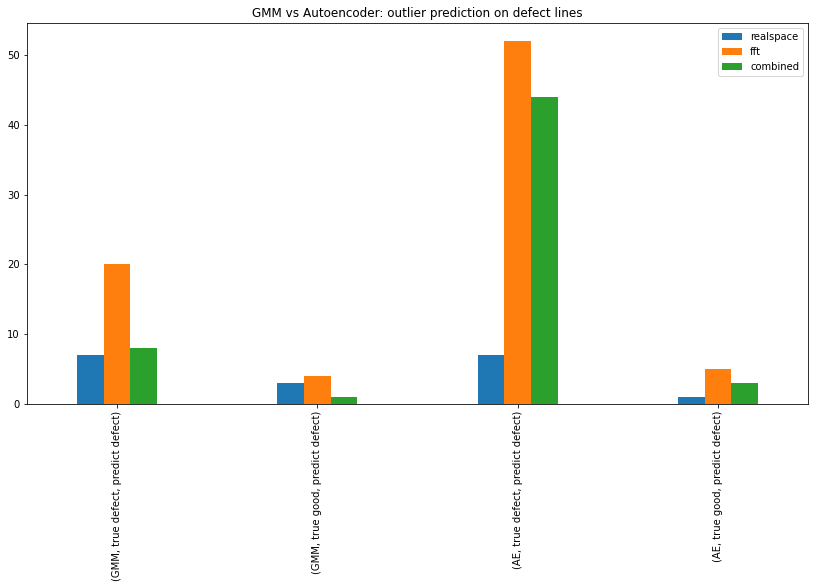

                     GMM                            AE               
             true defect      true good    true defect      true good
          predict defect predict defect predict defect predict defect
realspace              7              3              7              1
fft                   20              4             52              5
combined               8              1             44              3


In [66]:
index = ['GMM','AE']

df = pd.concat([df_gmm, df_ae], axis=0, sort=False, keys=index)

fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111)
ax.set_title('GMM vs Autoencoder: outlier prediction on defect lines')

df.plot.bar(ax=ax, width = 0.4)
plt.show()
print(df.T)

# Visualisierung des Datensets mit t-SNE

Die Datensets werden mithilfe des t-SNE auf 2 Dimensionen reduziert und visualisiert.

In [50]:
lab = ['0 defect realspace','0 defect fft','0 defect combined']
D_tsne = []
G_tsne = []
lr = 500

p = [30] 

for d, l in zip([Dp, Dpfft, Dpcomb],lab):
    for ind, i in enumerate(p):
        print(f'##############\n{ind+1}/{len(p)}: t-sne p={i} learning_rate={lr} for {np.shape(d)} {l}\n##############')
        tsne = TSNE(n_components=2,  perplexity=i, learning_rate=lr, verbose=0, angle=0.2, n_jobs=-1)
        Y = tsne.fit_transform(d)

        if l in '0 defect':
            D_tsne.append(Y)
        else:
            G_tsne.append(Y)

##############
1/1: t-sne p=30 learning_rate=500 for (17089, 84) 0 defect realspace
##############
##############
1/1: t-sne p=30 learning_rate=500 for (17089, 54) 0 defect fft
##############
##############
1/1: t-sne p=30 learning_rate=500 for (17089, 104) 0 defect combined
##############


############## plot AE (17089, 2) 0 defect realspace  for p = [30] ####################################################################


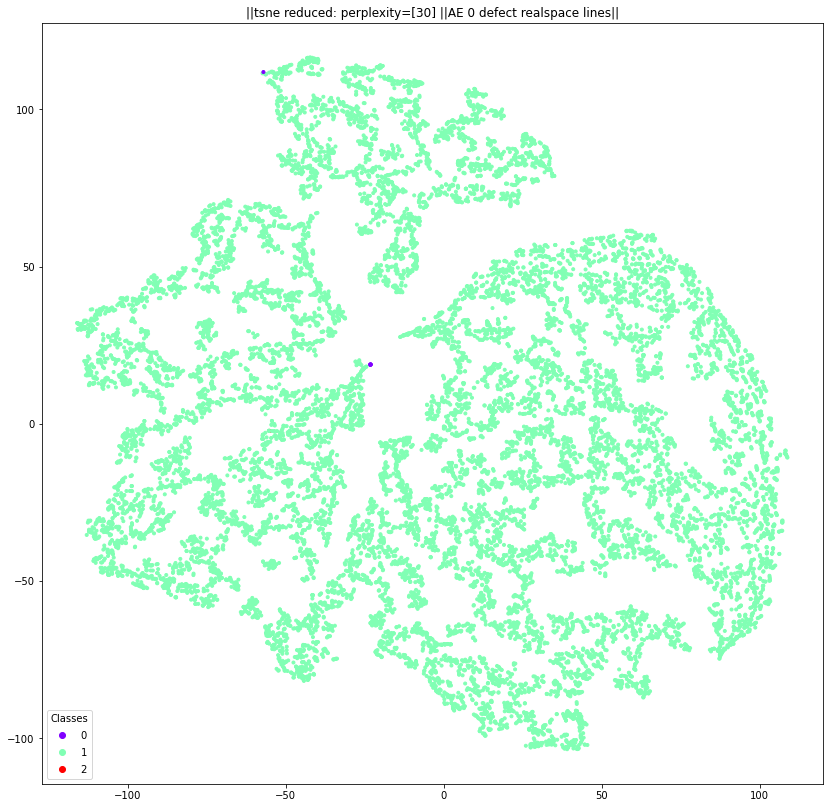

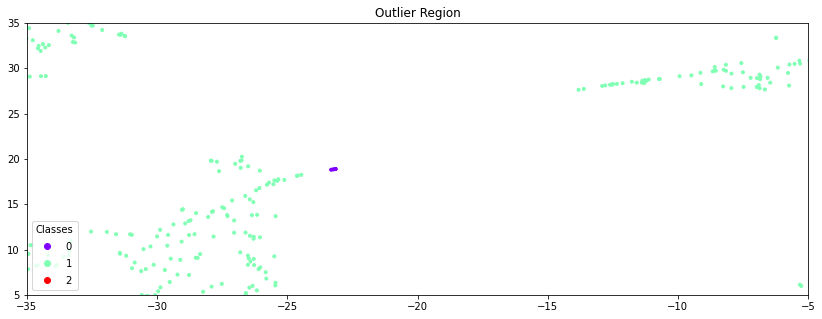

############## plot AE (17089, 2) 0 defect fft  for p = [30] ####################################################################


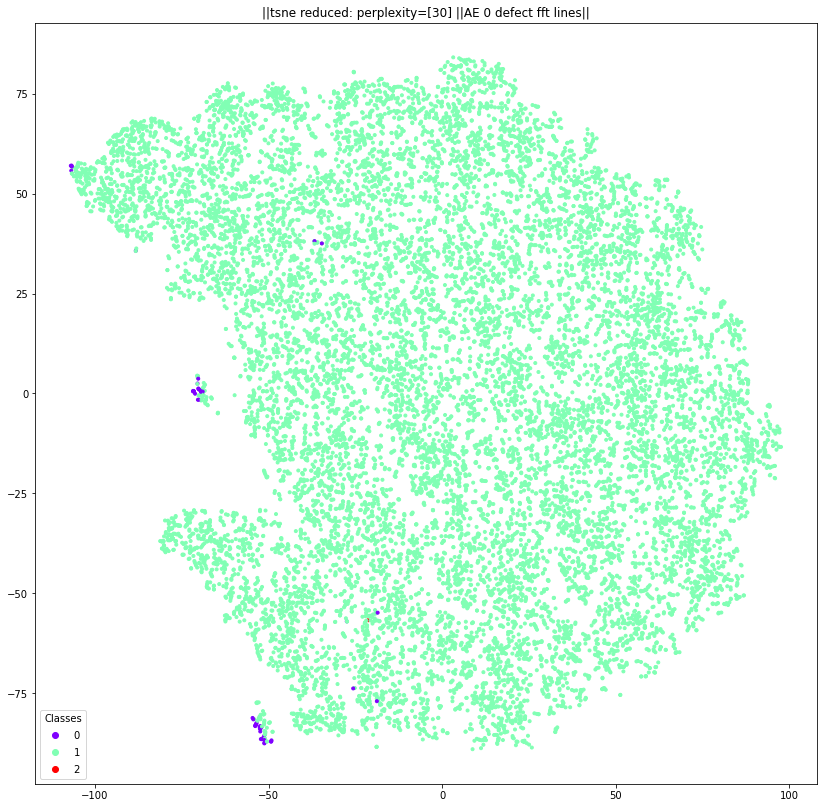

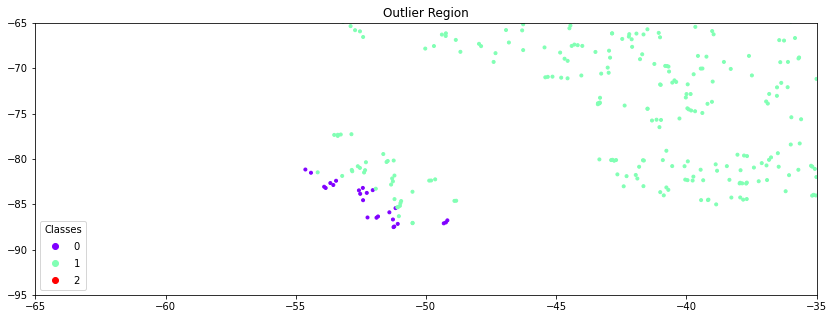

############## plot AE (17089, 2) 0 defect combined  for p = [30] ####################################################################


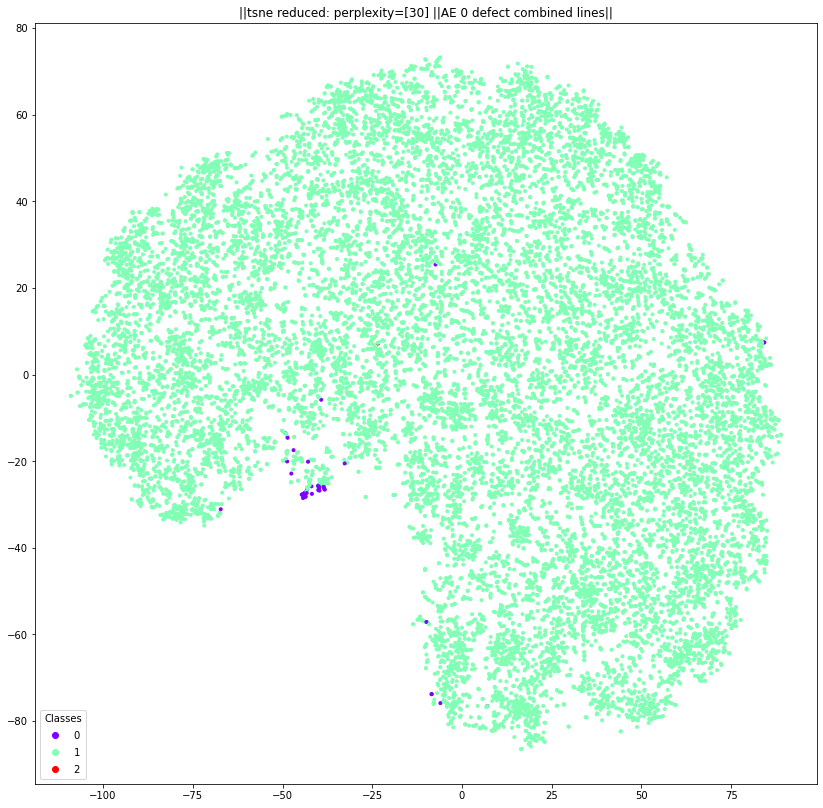

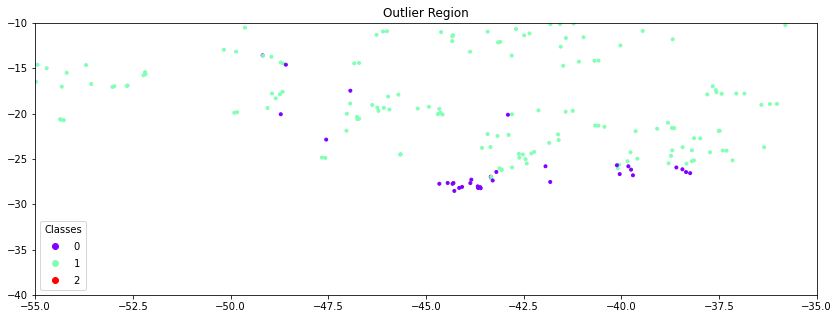

############## plot GMM (17089, 2) 0 defect realspace  for p = [30] ####################################################################


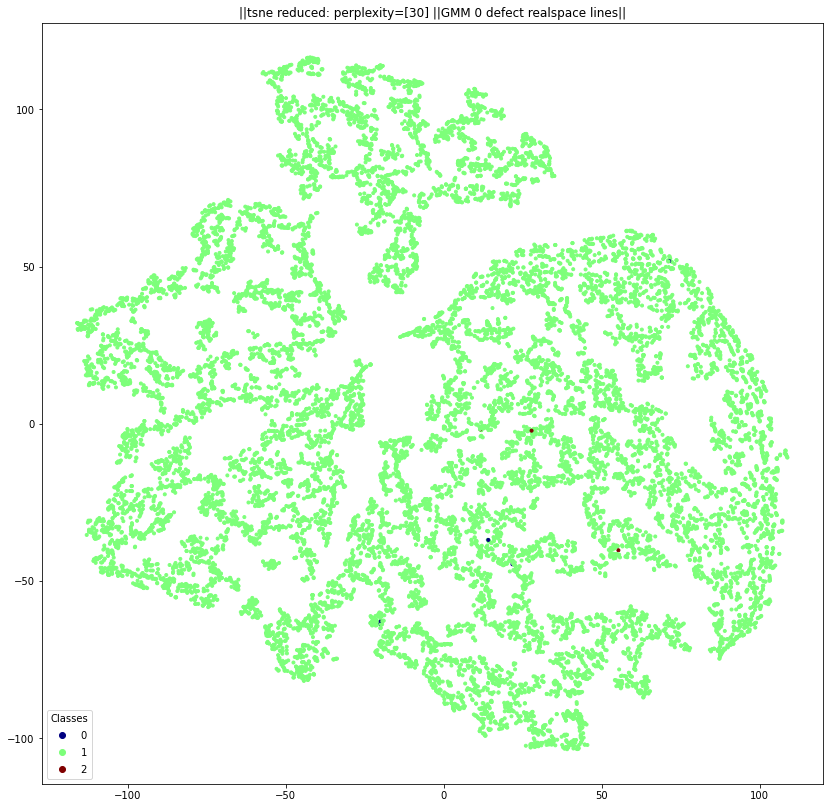

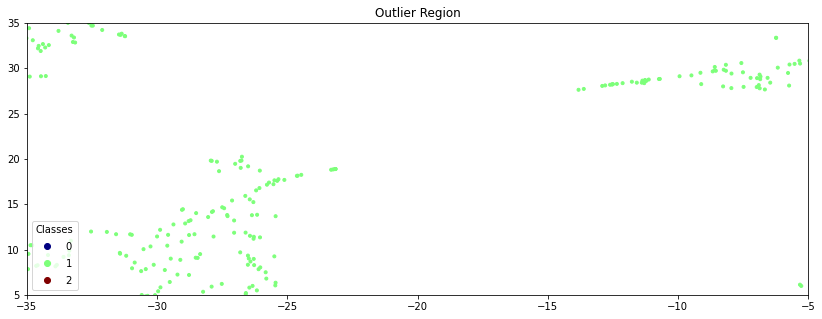

############## plot GMM (17089, 2) 0 defect fft  for p = [30] ####################################################################


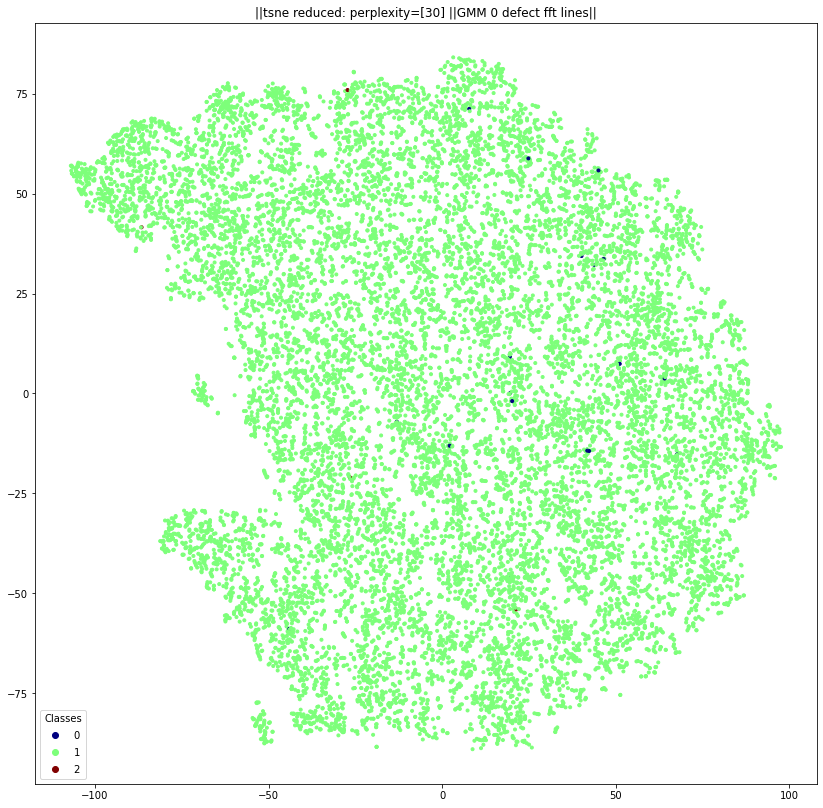

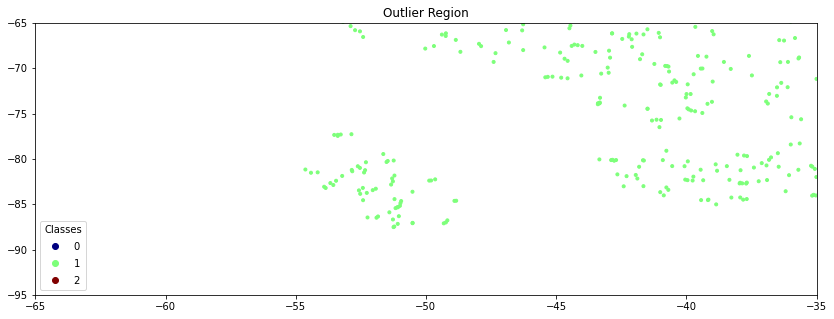

############## plot GMM (17089, 2) 0 defect combined  for p = [30] ####################################################################


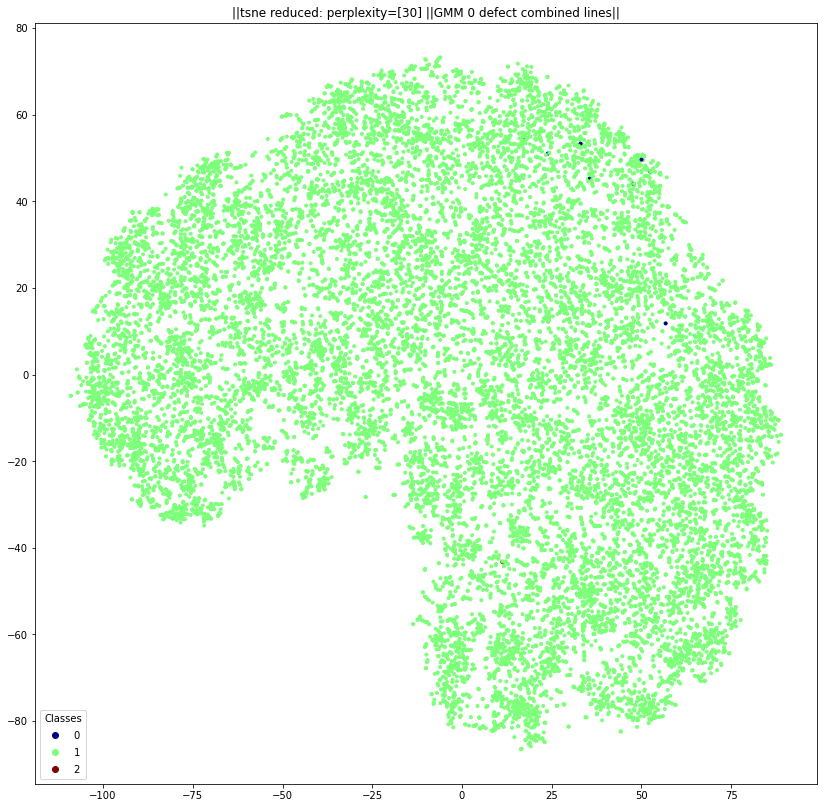

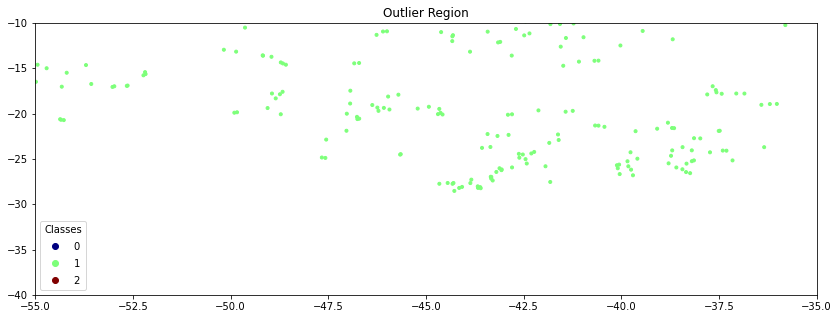

In [71]:
index = ['AE','GMM']
lab = ['0 defect realspace','0 defect fft','0 defect combined']
y_preds_ae = [y_pred_ae, y_pred_aefft, y_pred_aecomb]
y_preds_gmm = [y_pred_gmm, y_pred_gmmfft,y_pred_gmmcomb]
y_preds=[y_preds_ae, y_preds_gmm]
cmaps = [cm.rainbow, cm.jet]
xrange = [[-35, -5],[-65, -35],[-55, -35]]
yrange = [[5, 35],[-95, -65],[-40, -10]]

for d, la, y_pred, cma, indx in zip([G_tsne, G_tsne], [lab, lab], y_preds, cmaps, index):
    
    for i, X, xra, yra, y, l in zip(count(), d, xrange, yrange, y_pred, la):
        print('############## plot',indx,np.shape(Y), l,' for p =',p,'####################################################################')
        fig = plt.figure(figsize=(14,14))
        
        ax3 = fig.add_subplot(111)
        ax3.set_title(f'||tsne reduced: perplexity={p} ||{indx} {l} lines||')
        scat3 = ax3.scatter(X[:,0], X[:,1], marker='.', c=y,  cmap=cma)
        plt.legend(*scat3.legend_elements(), loc="lower left",  title="Classes")
        plt.show()
        
        fig = plt.figure(figsize=(14,5))

            
        ax = fig.add_subplot(111)
        ax.set_title(f'Outlier Region')
        ax.set_xlim(xra)
        ax.set_ylim(yra)
        scat = ax.scatter(X[:,0], X[:,1], marker='.', c=y,  cmap=cma)
        plt.legend(*scat.legend_elements(), loc="lower left", title="Classes")

        
        plt.show()

In [ ]:
dill.dump_session('notebook_env.db')

# Fazit

Abschließend ist zu sagen, dass die Ermittlung von Outliern über den Rekonstruktionsfehler gut funktioniert hat. Besonders geeignet ist hierfür scheinbar das kombinierte Datenset, wobei noch zu klären ist ob eine Skalierung der anderen Datensets, die Erkennungsrate eventuell verbessert.
Insbesondere der realspace würde davon vermutlich profitieren, da es sich hierbei um eine Spannungsflanke handelt, welche über die Zeit, einen deutlich unterschiedlichen Wertebreich hat.

Der Threshold für den Autoencoder wurde etwas (1/5) unter dem maximalen loss der good lines angesetzt um teils mehr Outlier zu identifizieren, auf kosten von wenigen false positives.

Unter Anwendung verschiedener Gaussian Mixture Models wurden deutlich weniger Outlier identifiziert, bei einer ähnlichen false positive rate. Es handelt sich dabei auch um andere Datenpunkte, als die vom Autoencoder identifizierten. Die Outlier des Autoencodermodells liegen im mithilfe des t-SNE Algorithmus visualisierten eher am Rand, wohingegen die der Gaussian Mixture Models eher verteilt. Beim kombinierten Datenset befinden sie sich meist in einer Ecke.

Es wurden ausschließlich die mittels PCA reduzierten Datensets verwendet um den Einfluss des "Fluches der Dimensionen" zu reduzieren. 
Besonders Effektiv scheint dies beim kombinierten Datenset zu sein, da sich die Anzahl bei diesem Datenset dritteln lies und dennoch die meisten Outlier über den Rekonstruktionsfehler aufzeigte.

Beim kombinierten Datenset könnten noch andere Kombinationsverfahren untersucht werden. In diesem Projekt wurde der realspace hinter den fftspace gekettet.

Es können auch mehrere Analyseverfahren eingesetzt werden (F-test, Korrelationskoeffizient,..) um eine sinnvolle Vorauswahl an Features zu treffen, bevor das gesammte Datenset per PCA reduziert wird.

Da die Algorithmen ausschließlich mit den goodlines trainiert worden sind kann man auch von Novelty Detection sprechen.
Ein bewährter Ansatz, wären unter Anderem One Class SVM, welche über ihre ermittelten Stützvektoren Grenzen zu Novelties setzen. 

Ein weiterer Ansatz zur Outlier Detection wären Isolation Forests, welche im Prinzip ein vielzahl von stark begrenzten Decision Trees sind. Diesen Ansatz nennt man auch Ensemble Learning.